In [1]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})

# Support Vector Machines

# Supervised learning

Data $T = \left\{(\vec x_1, y_1), (\vec x_2, y_2), ..., (\vec x_M, y_M) \right\}$

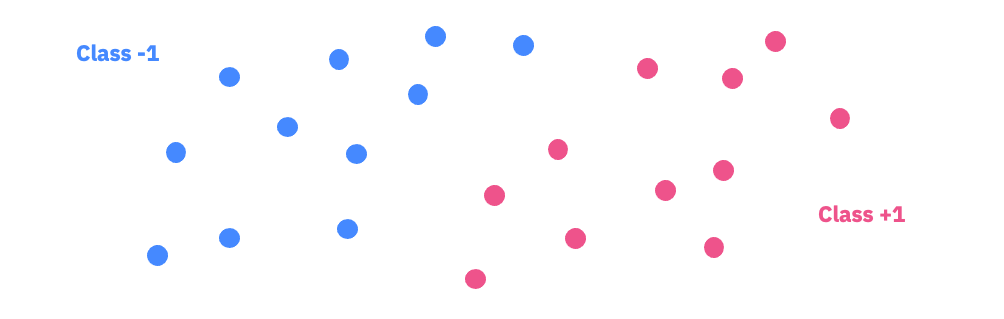

We seek: A function $c$ to assign the right labels: $$c: T \rightarrow \{1, -1\}$$

### This setting occurs everywhere!

* Image classification
* Facial recognition
* Spam detection
* ...

# Outline

In each lecture, we increase the amount of work a Quantum Computer is doing:

1. SVM
2. Quantum SVM
3. Variational Quantum Classifier

# Support Vector Machine (SVM)

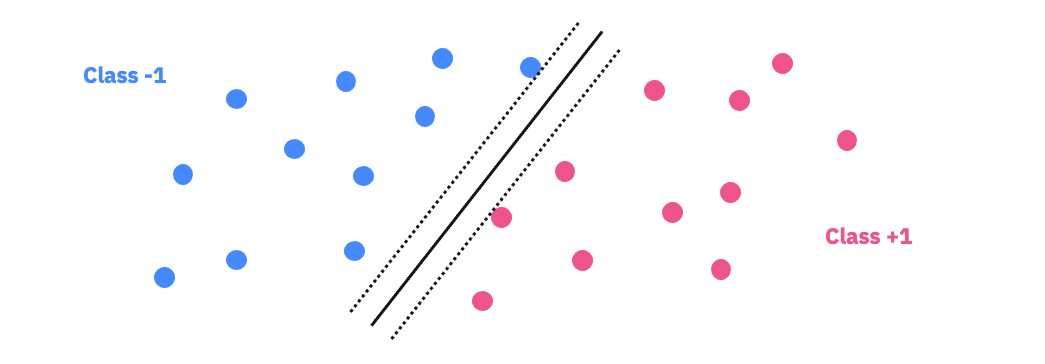

Find a hyperplane ($=n-1$ dimensional plane) that separates the classes _with largest margin_.

The vector that defines this hyperplane is called _support vector_

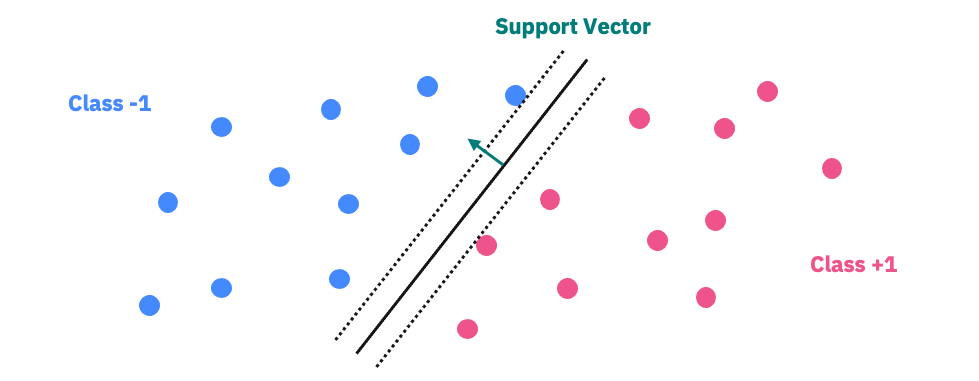

We can find it by solving 

$$
\begin{aligned}
\min_{\vec w \in \mathbb{R}^n, b \in \mathbb{R}}&~~ ||\vec w||^2 \\
\text{subject to }& \forall i: y_i(\vec w^T \vec x_i - b) \geq 1
\end{aligned}
$$

Then we classify a new point $\vec p$ as 
$$
c(\vec p) = \text{sign}(\vec w^T \vec p + b) \in \{-1, 1\}
$$

### Example

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def clouds(num_points=100):
    centers = [(1, 1), (-1, -1)]
    spreads = [0.5, 0.7]
    labels = [-1, 1]
    
    X = []
    y = []
    for center, spread, label in zip(centers, spreads, labels):
        X += np.random.multivariate_normal(center, spread * np.identity(2), num_points).tolist()
        y += [label] * num_points
        
    return X, y

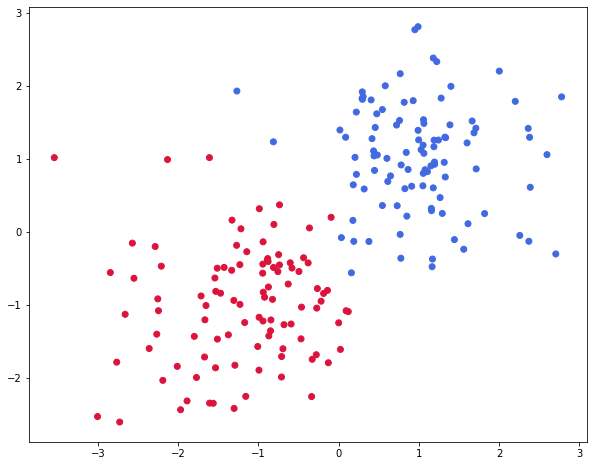

In [31]:
X, y = clouds(100)

colors = ["crimson" if label == 1 else "royalblue" for label in y]
plt.figure(figsize=(10, 8))
plt.scatter(np.array(X)[:,0], np.array(X)[:,1], color=colors);

#### Defining the loss function

We include the constraint that we need to classify the data correctly as penalty with weight $\lambda > 0$:

$$
    \ell(\vec w, b) = ||\vec w||^2 + \lambda \sum_{i=1}^n \text{max}(0, 1 - y_i (\vec w^T \vec x_i - b))
$$

The larger $\lambda$, the more important it is to classify the data correctly.

In [32]:
def loss(support_vector, X, y, penalty=1e5):
    w = support_vector[1:]
    b = support_vector[0]
    
    norm = np.linalg.norm(w) ** 2
    constraint = sum(max(0, 1 - y[i] * (w.dot(X[i]) - b)) for i, _ in enumerate(y))
    
    return norm + penalty * constraint

#### Now minimize the loss

In [33]:
from qiskit.algorithms.optimizers import L_BFGS_B

optimizer = L_BFGS_B()
result = optimizer.minimize(lambda sv: loss(sv, X, y), x0=np.random.random(3))
support_vector = result.x

In [34]:
def classify(point, support_vector):
    w = support_vector[1:]
    b = support_vector[0]
    
    return np.sign(w.dot(point) + b)

#### And now we can predict!

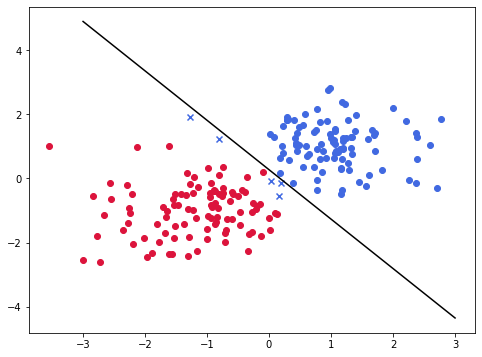

In [37]:
predicted = [classify(point, support_vector) for point in X]
colors = ["crimson" if label == 1 else "royalblue" for label in y]
markers = ["o" if label == predicted_label else "x" for label, predicted_label in zip(y, predicted)]
plt.figure(figsize=(8, 6))
for point, marker, color in zip(X, markers, colors):
    plt.scatter(point[0], point[1], color=color, marker=marker)
    
b, w = support_vector[0], support_vector[1:]
x1 = np.linspace(-3, 3, num=100)
x2 = -1 / w[1] * (w[0] * x1 + b)
plt.plot(x1, x2, "k-");

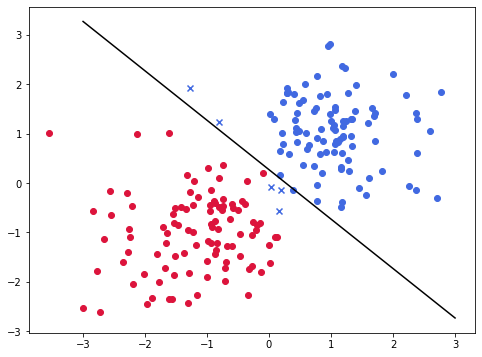

In [39]:
predicted = [classify(point, support_vector) for point in X]
colors = ["crimson" if label == 1 else "royalblue" for label in y]
markers = ["o" if label == predicted_label else "x" for label, predicted_label in zip(y, predicted)]
plt.figure(figsize=(8, 6))
for point, marker, color in zip(X, markers, colors):
    plt.scatter(point[0], point[1], color=color, marker=marker)
    
b, w = support_vector[0], support_vector[1:]
x1 = np.linspace(-3, 3, num=100)
x2 = -1 / w[1] * (w[1] * x1 + b)
plt.plot(x1, x2, "k-");

In [38]:
w

array([-6.40897408, -4.16140485])

#### Or just use the ``sklearn`` package

In [8]:
from sklearn.svm import SVC  # support vector classifier 

model = SVC()
model.fit(X, y)

sk_predict = model.predict(X)

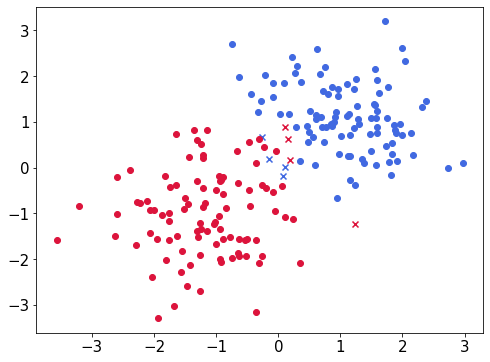

In [9]:
colors = ["crimson" if label == 1 else "royalblue" for label in y]
markers = ["o" if label == predicted_label else "x" for label, predicted_label in zip(y, sk_predict)]
plt.figure(figsize=(8, 6))
for point, marker, color in zip(X, markers, colors):
    plt.scatter(point[0], point[1], color=color, marker=marker)

## Non-linear data

In [10]:
def circle():
    num_points = 250
    points = 1 - 2 * np.random.random((num_points, 2))
    
    radius = 0.6
    labels = [1 if np.linalg.norm(point) > radius else -1 for point in points]
    
    return points, labels

Text(0, 0.5, '$x_2$')

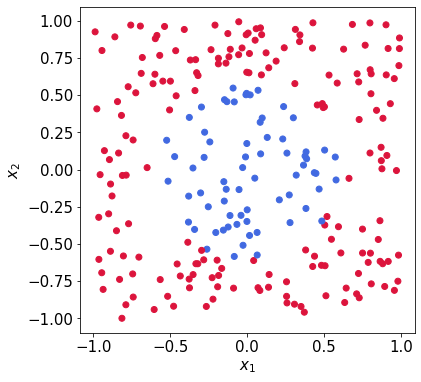

In [11]:
points, labels = circle()
colors = ["crimson" if label == 1 else "royalblue" for label in labels]

plt.figure(figsize=(6, 6))
plt.scatter(points[:, 0], points[:, 1], color=colors)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

**Idea** Embed data in a higher dimensional space, maybe it is linearly separable there?

In [12]:
def feature_map(x):
    return np.array([x[0], x[1], x[0] ** 2 + x[1] ** 2])

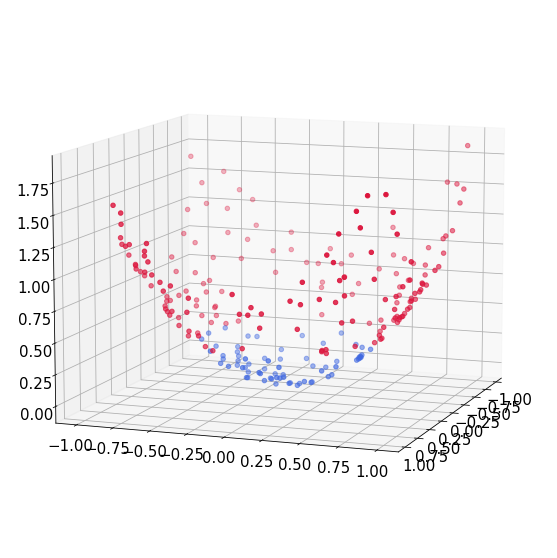

In [13]:
embedded_points = np.array([feature_map(point) for point in points])

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(embedded_points[:, 0], embedded_points[:, 1], embedded_points[:, 2], color=colors)
ax.view_init(10, 20)

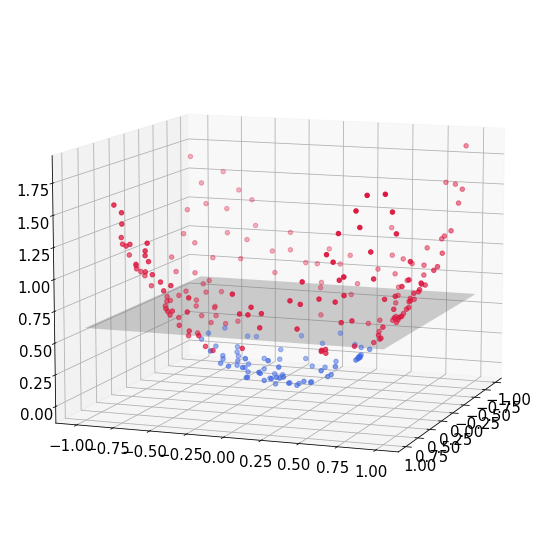

In [14]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(embedded_points[:, 0], embedded_points[:, 1], embedded_points[:, 2], color=colors)

x, y = np.meshgrid([1, -1], [1, -1])
ax.plot_surface(x, y, 0.6 * np.ones_like(x), alpha=0.3, color="grey")

ax.view_init(10, 20)

Text(0, 0.5, '$x_2$')

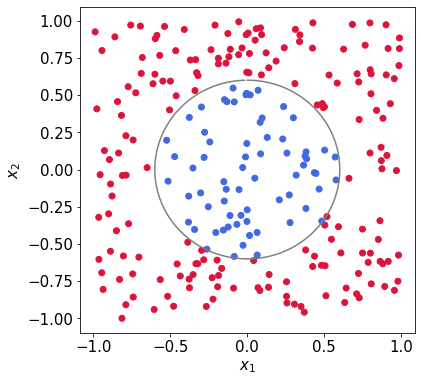

In [15]:
plt.figure(figsize=(6, 6))
plt.scatter(points[:, 0], points[:, 1], color=colors)

angles = np.linspace(0, 2 * np.pi, num=200, endpoint=False)
x = 0.6 * np.sin(angles)
y = 0.6 * np.cos(angles)
plt.plot(x, y, color="grey")

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

#### In math language

We introduce a nonlinear feature transformation $\phi$ into a Hilbert space $\mathcal{V}$

$$
\phi: \mathbb{R}^n \rightarrow \mathcal{V}
$$

(Hilbert space: Vector space with an inner product, i.e. we can compute $\langle \vec x, \vec y\rangle$)

Then our decision function is

$$
c(\vec p) = \text{sign}\left(\langle \vec w, \phi(\vec p)\rangle + b\right)
$$

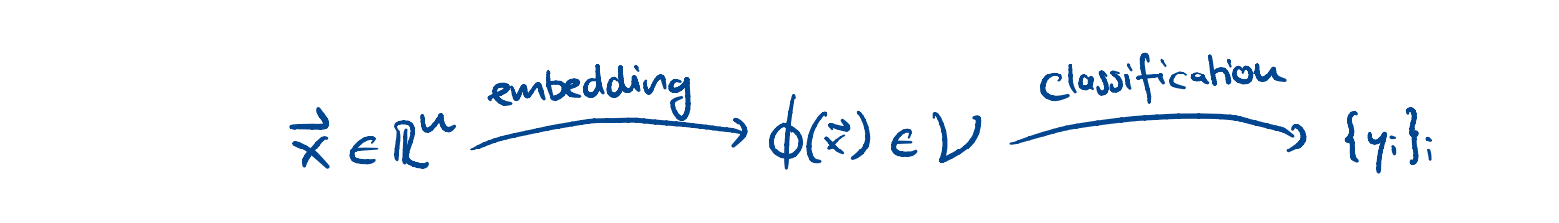

But what if the Hilbert space $\mathcal{V}$ is HUGE? Then evaluating the inner product is expensive!

### Kernel trick

Rewrite the objective function such that only inner products of the points are necessary

$$
\begin{aligned}
&\max_{\alpha} \sum_{i=1}^n \alpha_i - \frac{1}{2}\sum_{i,j=1}^n \alpha_i\alpha_j y_i y_j \underbrace{\vec x_i^T \vec x_j}_{= k(\vec x_i, \vec x_j)} \\
& \text{subject to } \sum_{i=1}^n \alpha_i y_i = 0
\end{aligned}
$$

Now, we can find feature maps $\phi$ such that evaluating the inner product 

$$
k(\vec x_i, \vec x_j) = \langle\phi(\vec x_i), \phi(\vec x_j)\rangle
$$

is **efficient**!

### Outline for "Quantum-fication"

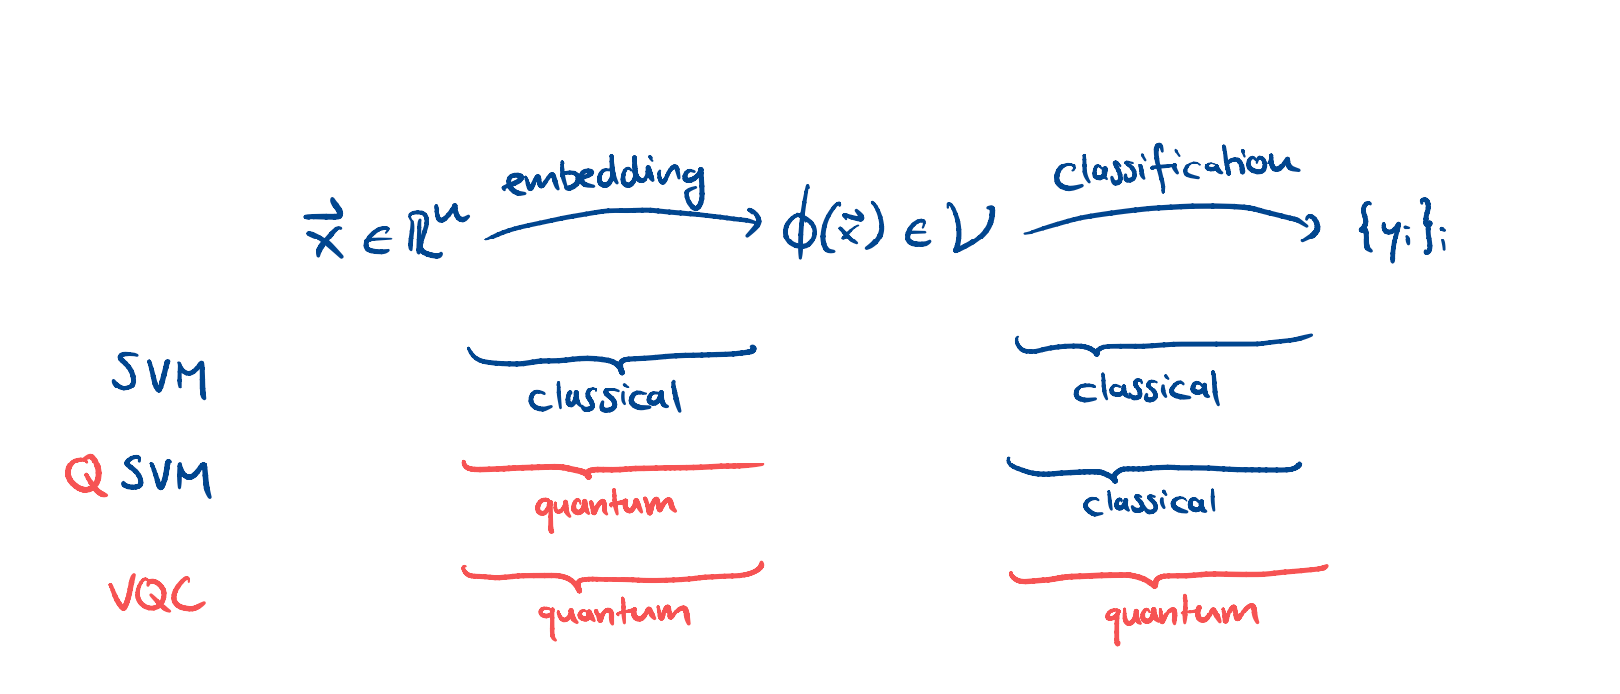

# Second lecture starts here

# Quantum SVM

## Recap: Supervised learning and Support Vector Machines (SVM)

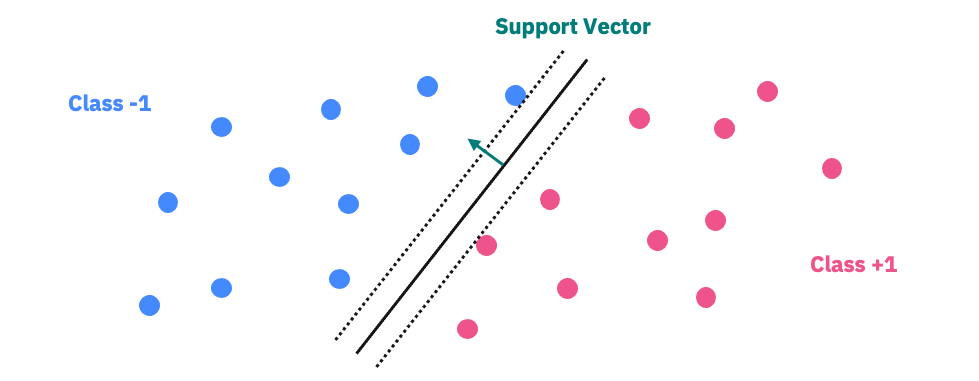

For data that's not linearly separable, embed the data in a (usually higher dimensional) space $\mathcal{V}$

$$
\phi: \mathbb{R}^n \rightarrow \mathcal{V}
$$

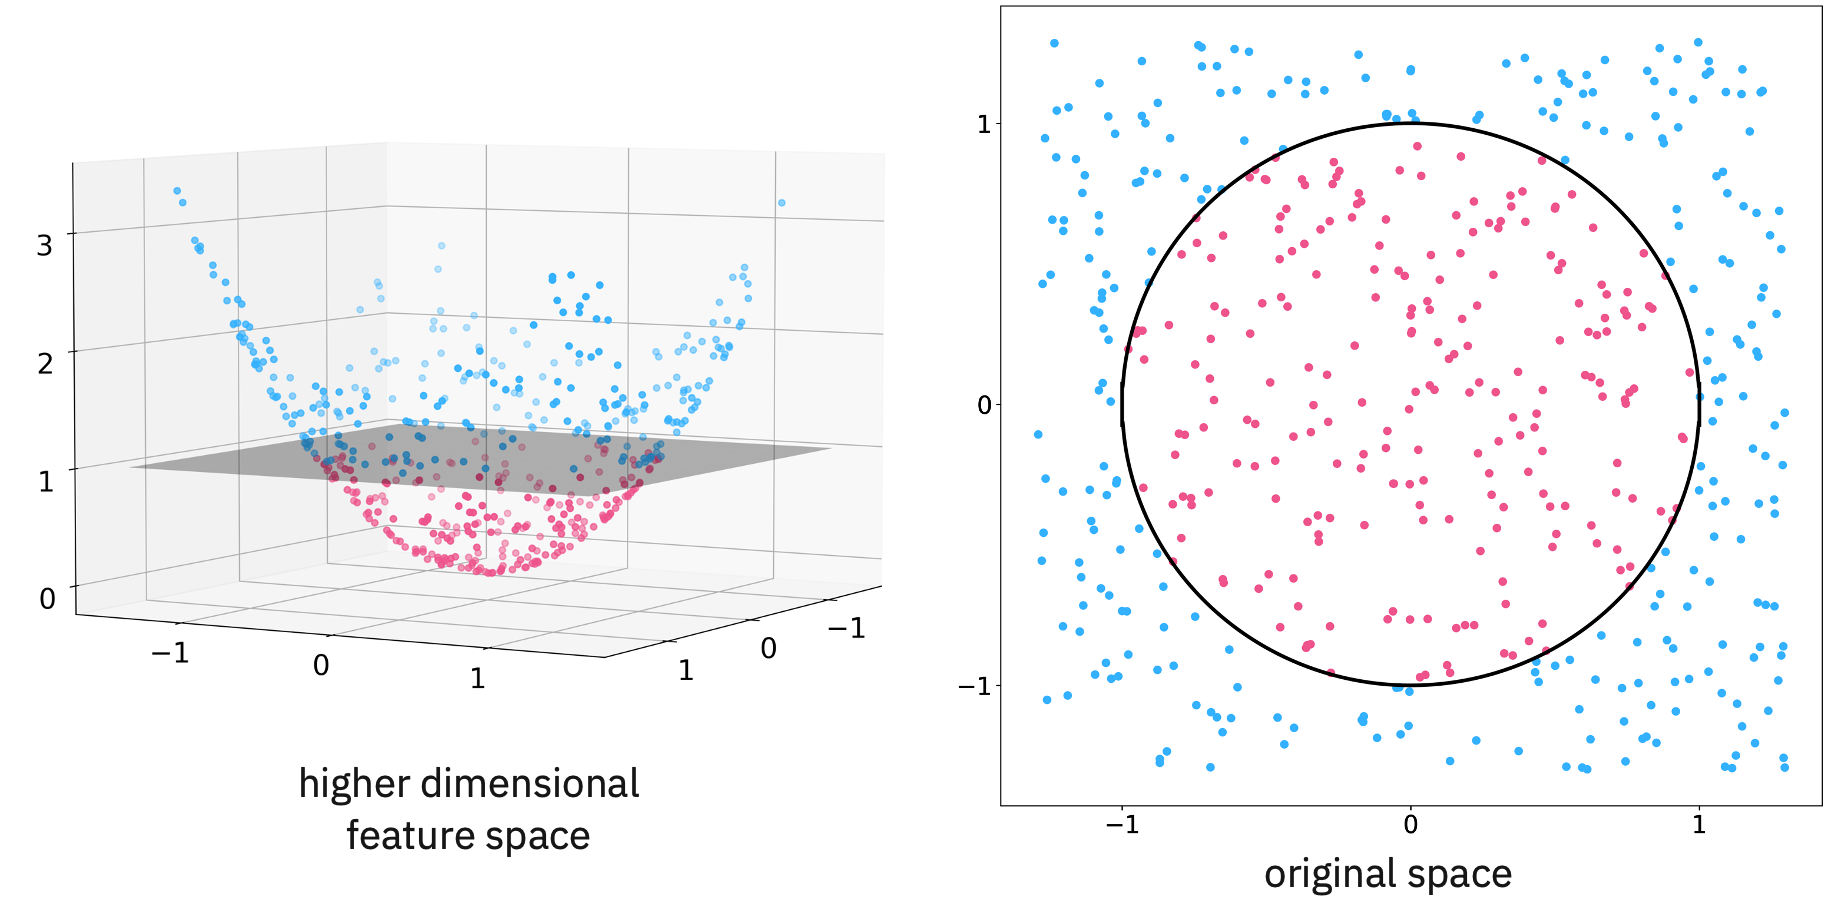

But how do we choose the space we map into? How do we choose $\mathcal{V}$ and $\phi$?

## The Hilbert space is a big place

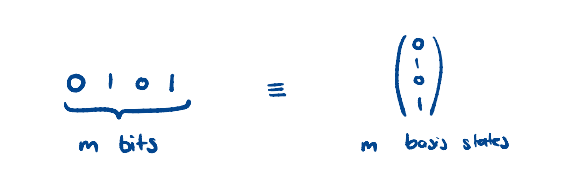

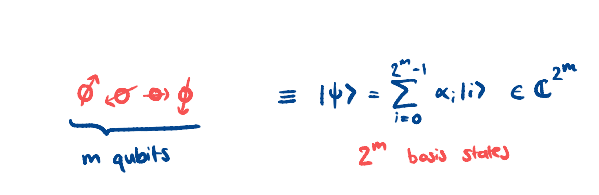

How large is $2^m$?
* 2 qubits: 4 states
* 10 qubits: 1024 states
* 125 qubits: more states than particles in the (observable) universe!

### The idea of Quantum SVM 
_Havlicek et al. Nature 567 7747_

Use the _exponentially large_ Hilbert space of qubits for the feature map!

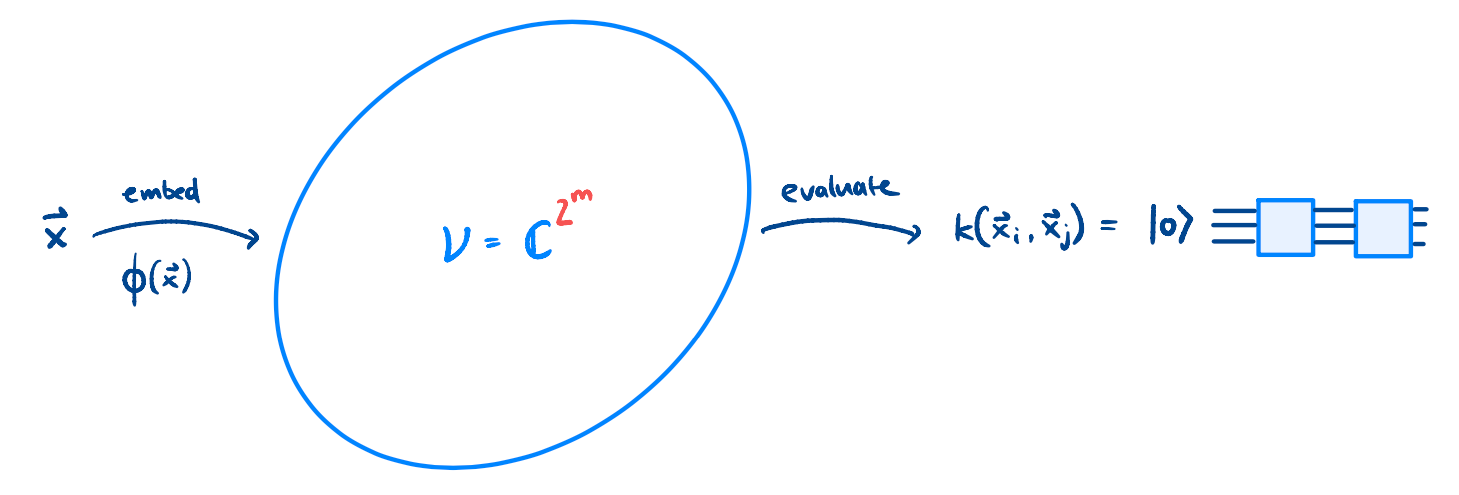

#### Is this better than classical feature maps?

For some data, we know it is! $\rightarrow$ _Liu et al. "A rigorous and robust quantum speed-up in supervised machine learning" Nat. Phys. 17, 1013–1017 (2021)._

But in general there is no proof that it works better for any dataset.

### Quantum Feature Map

How do we implement these quantum feature maps? With circuits $\mathcal{E}(\vec x)$!

$$
\begin{aligned}
\mathcal{E}~:~& \mathbb{R}^n \rightarrow \mathcal{V} \\
& \vec x \mapsto |\psi(\vec x)\rangle
\end{aligned}
$$

<center>
<div>
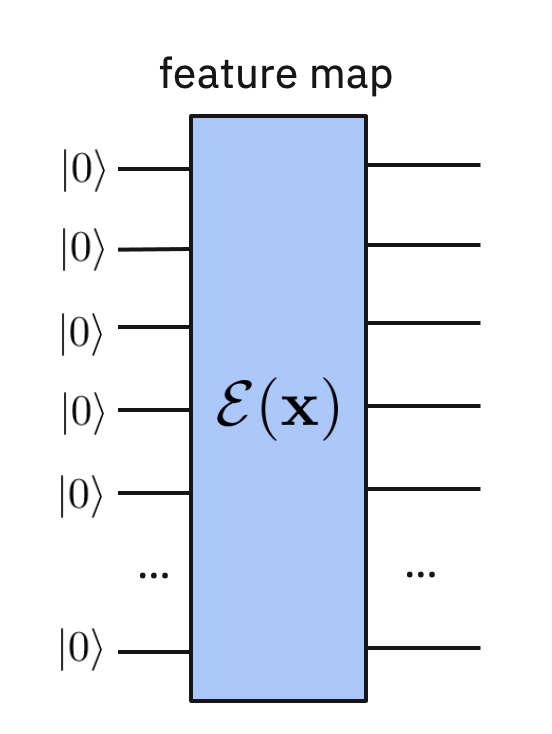
</div>
</center>

What about kernel evaluation?

$$
k(\vec x, \vec x') = |\langle\psi(\vec x') | \psi(\vec x)\rangle|^2 = |\langle 0 | \mathcal{E}^\dagger(\vec x') \mathcal{E}(\vec x)|0\rangle|^2
$$

<center>
<div>
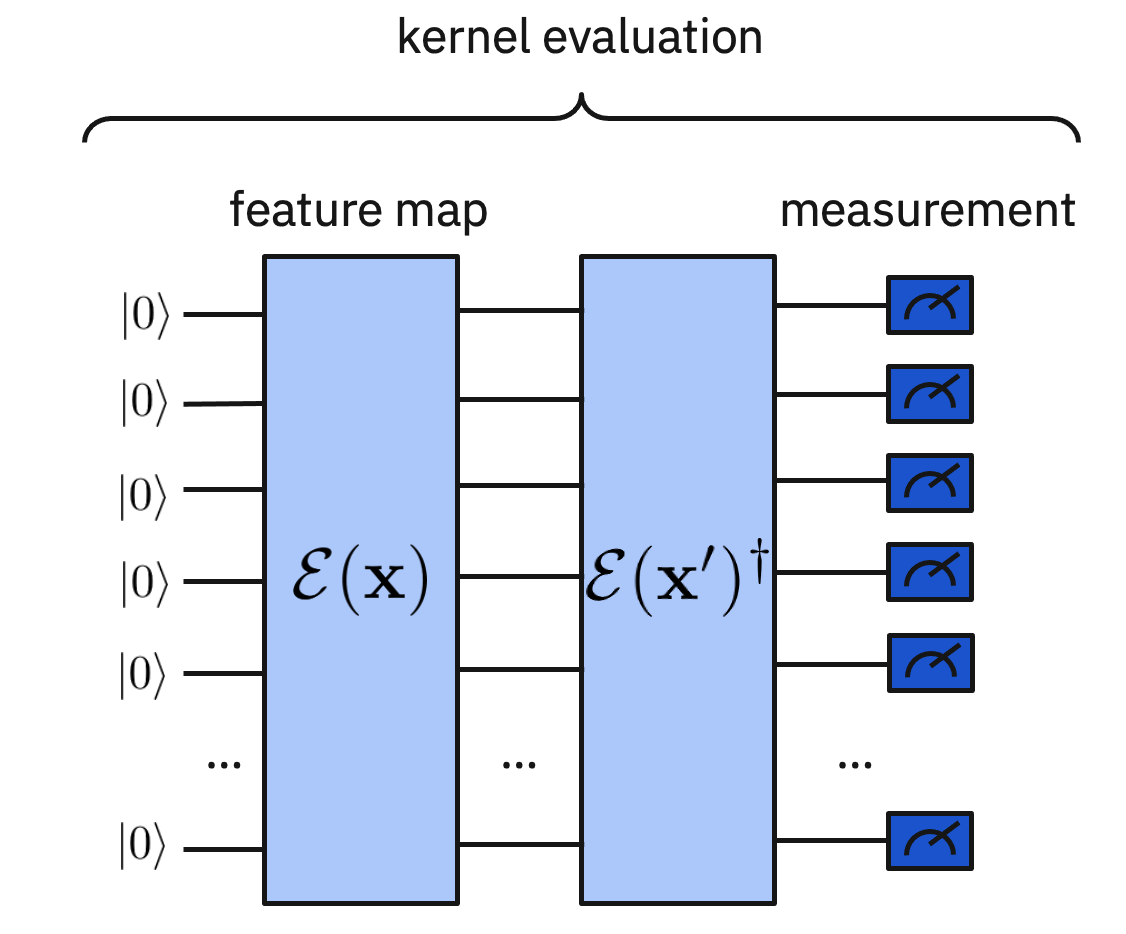
</div>
</center>

## Encoding data: How do we choose $\mathcal{E}$?

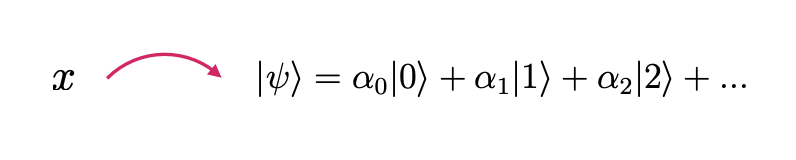

There are many different techniques! For example
* basis encoding
* amplitude encoding
* angle encoding
* phase encoding
* ...

### Angle encoding

_Schuld et al. "The effect of data encoding on the expressive power of variational quantum machine learning models" Phys. Rev. A 103, 032430 (2021)_

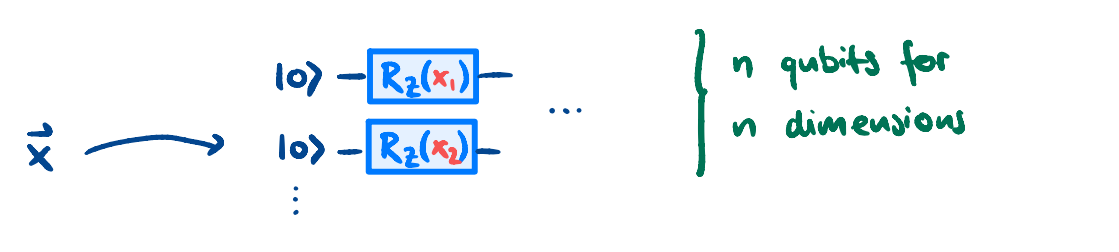

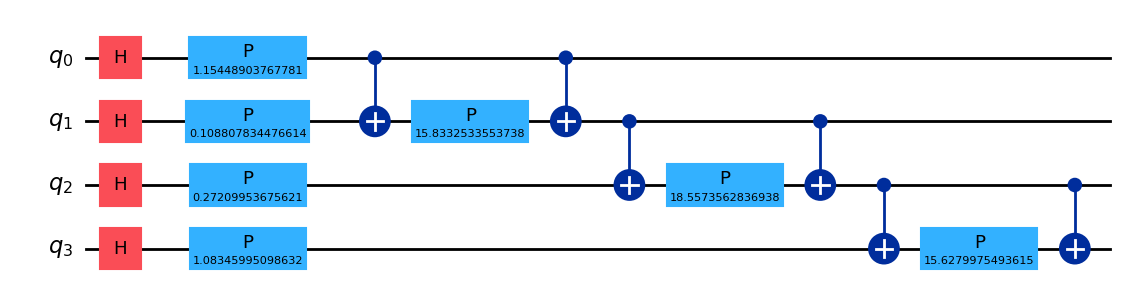

In [67]:
from qiskit.circuit.library import ZZFeatureMap

num_qubits = 4
x = np.random.random(num_qubits)

data = ZZFeatureMap(feature_dimension=num_qubits, reps=1, entanglement="linear")
data.assign_parameters(x, inplace=True)
data.decompose().draw("mpl", style="iqx", scale=1.4)

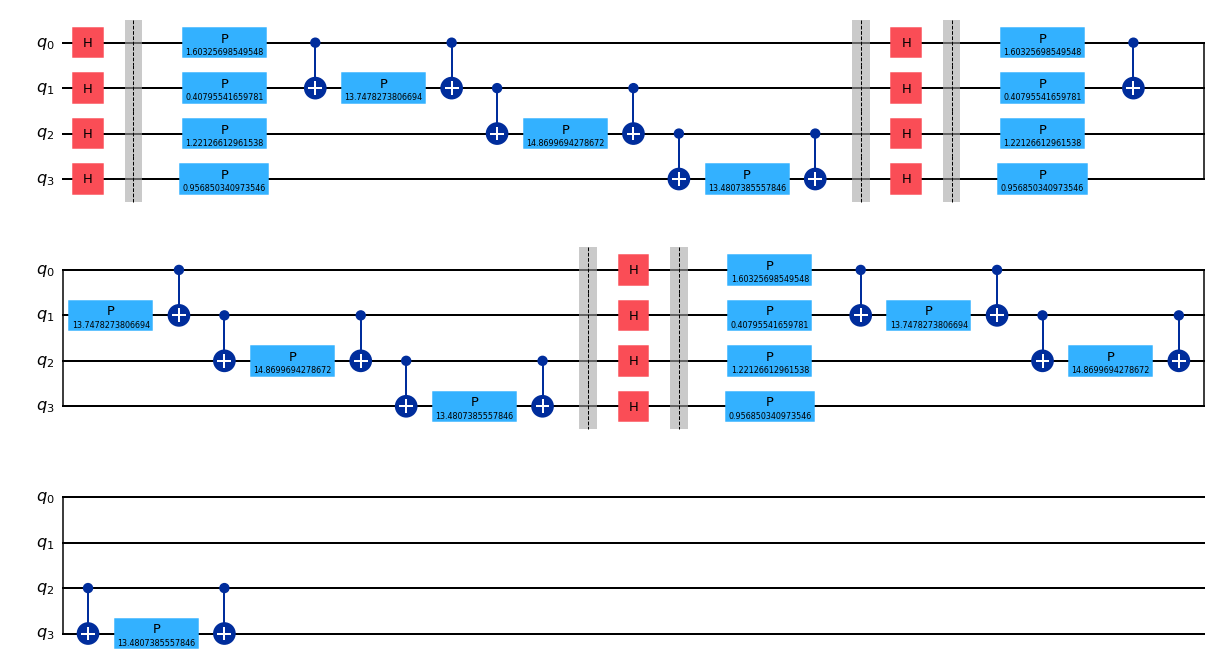

In [18]:
data = ZZFeatureMap(feature_dimension=num_qubits, reps=3, entanglement="linear", insert_barriers=True)
data.assign_parameters(x, inplace=True)
data.decompose().draw("mpl", style="iqx")

Also see: [the docs](https://qiskit.org/documentation/apidoc/circuit_library.html#data-encoding-circuits).

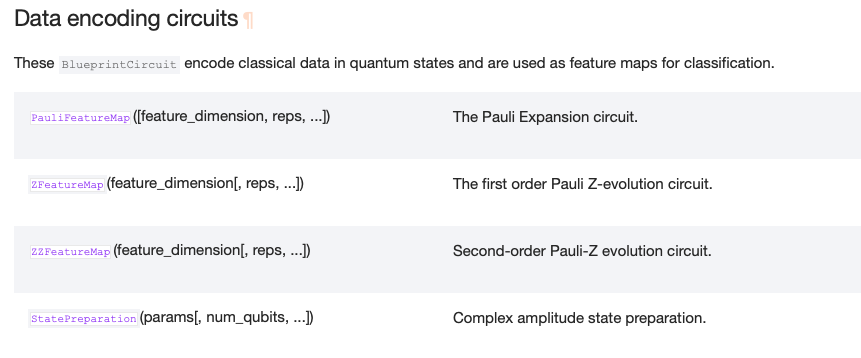

### Building a quantum kernel

In [23]:
from qiskit import transpile, BasicAer, QuantumCircuit

backend = BasicAer.get_backend("qasm_simulator")
shots = 1024

dimension = 2
feature_map = ZZFeatureMap(dimension, reps=1)

def evaluate_kernel(x_i, x_j):
    circuit = QuantumCircuit(dimension)
    circuit.compose(feature_map.assign_parameters(x_i), inplace=True)
    circuit.compose(feature_map.assign_parameters(x_j).inverse(), inplace=True)
    circuit.measure_all()
    
    transpiled = transpile(circuit, backend)
    counts = backend.run(transpiled, shots=shots).result().get_counts()
    
    return counts.get("0" * dimension, 0) / shots

In [24]:
evaluate_kernel(X[2], X[3])

0.080078125

Or use Qiskit directly!

In [25]:
from qiskit_machine_learning.kernels import QuantumKernel

kernel = QuantumKernel(feature_map, quantum_instance=backend)
kernel.evaluate(X[2], X[3])

array([[0.09277344]])

#### Classification

Text(0, 0.5, '$x_2$')

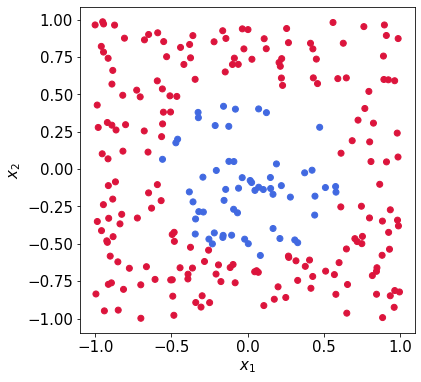

In [26]:
points, labels = circle()
colors = ["crimson" if label == 1 else "royalblue" for label in labels]

plt.figure(figsize=(6, 6))
plt.scatter(points[:, 0], points[:, 1], color=colors)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

In [27]:
qsvm = SVC(kernel=kernel.evaluate)
qsvm.fit(points, labels)
predicted = qsvm.predict(points)

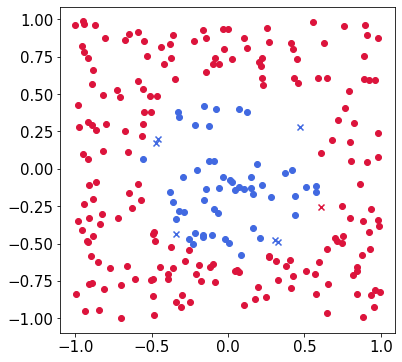

In [28]:
markers = ["o" if label == predicted_label else "x" for label, predicted_label in zip(labels, predicted)]
plt.figure(figsize=(6, 6))
for point, marker, color in zip(points.tolist(), markers, colors):
    plt.scatter(point[0], point[1], color=color, marker=marker)

# Variational Quantum Classifier

## Recap: SVM and Quantum SVM

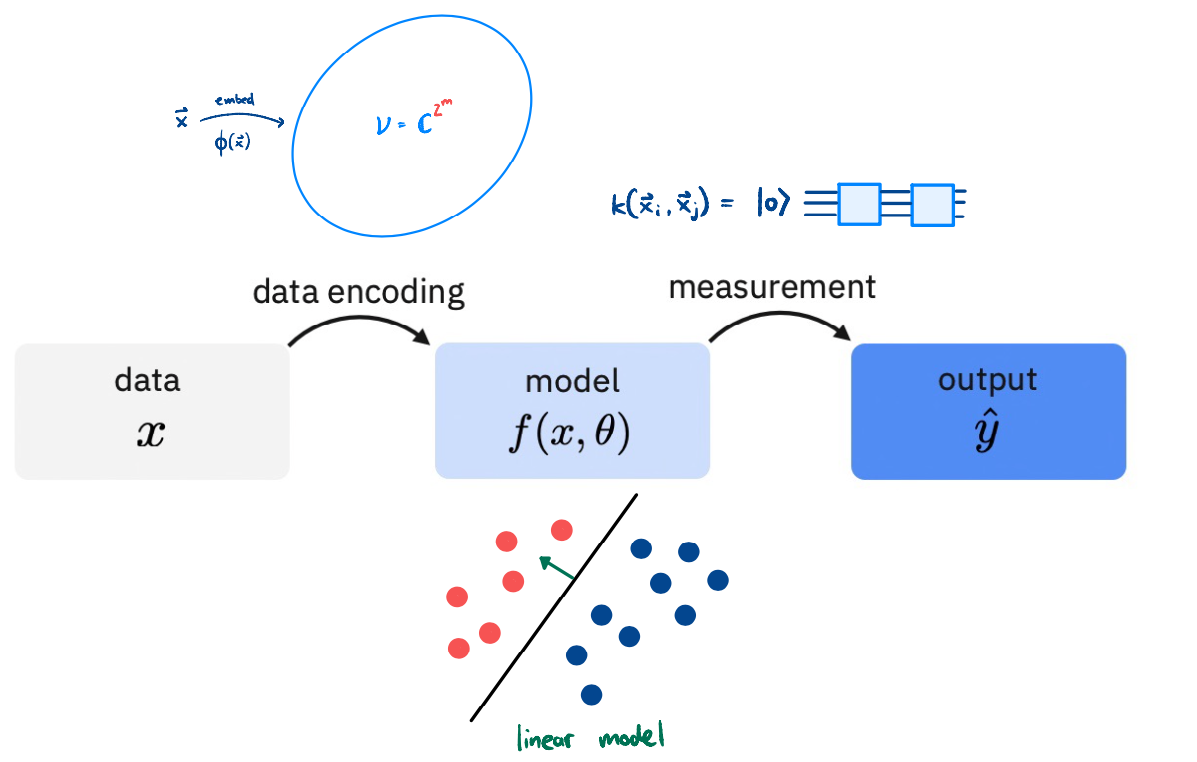

## Quantum Model?

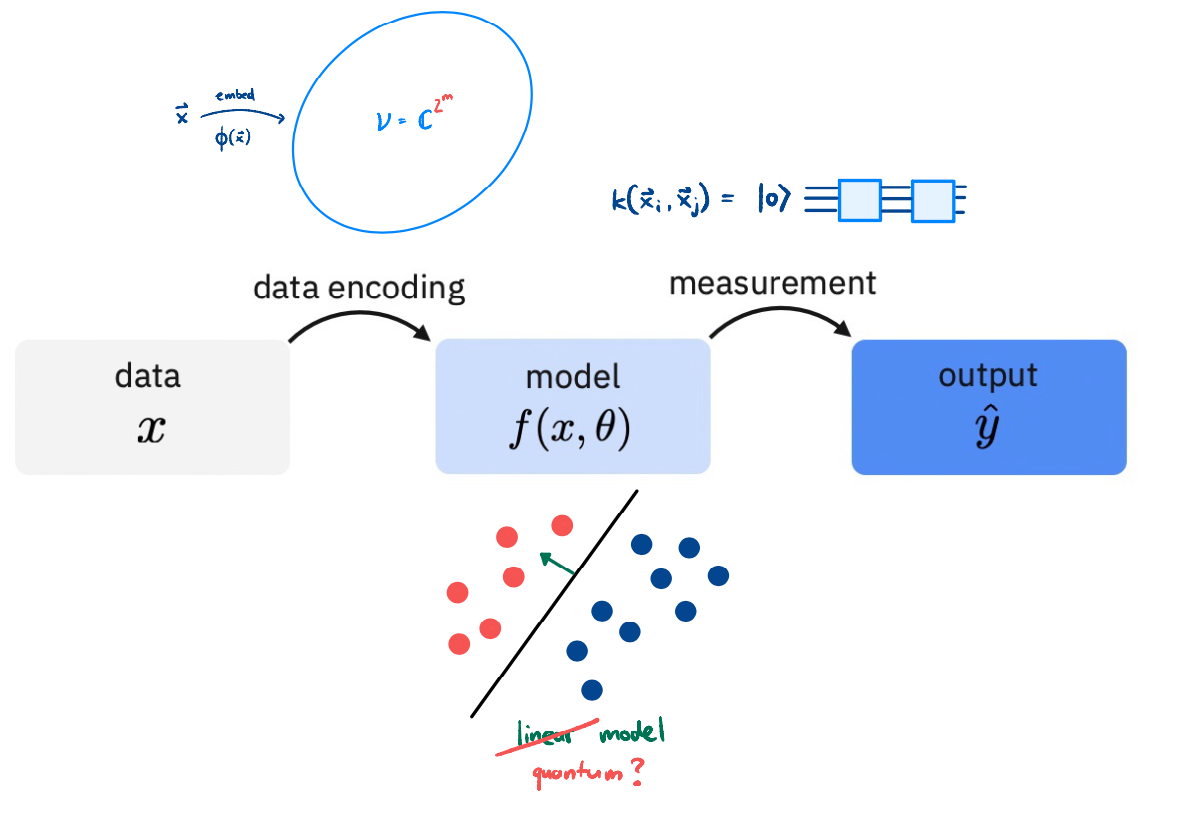

### Variational Quantum Classifier

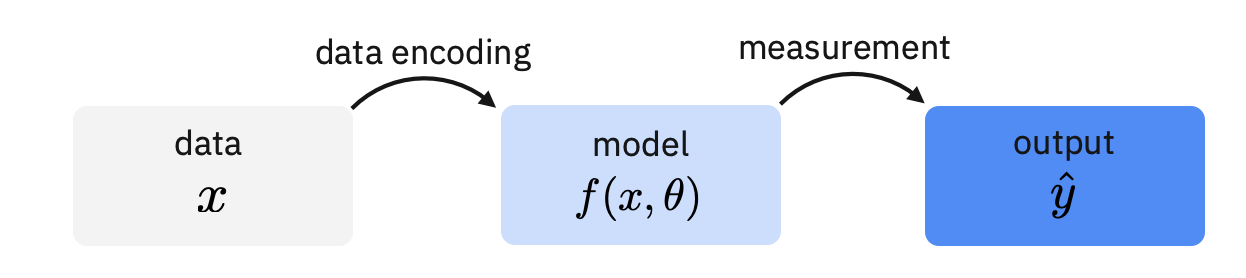

<center>
<div>
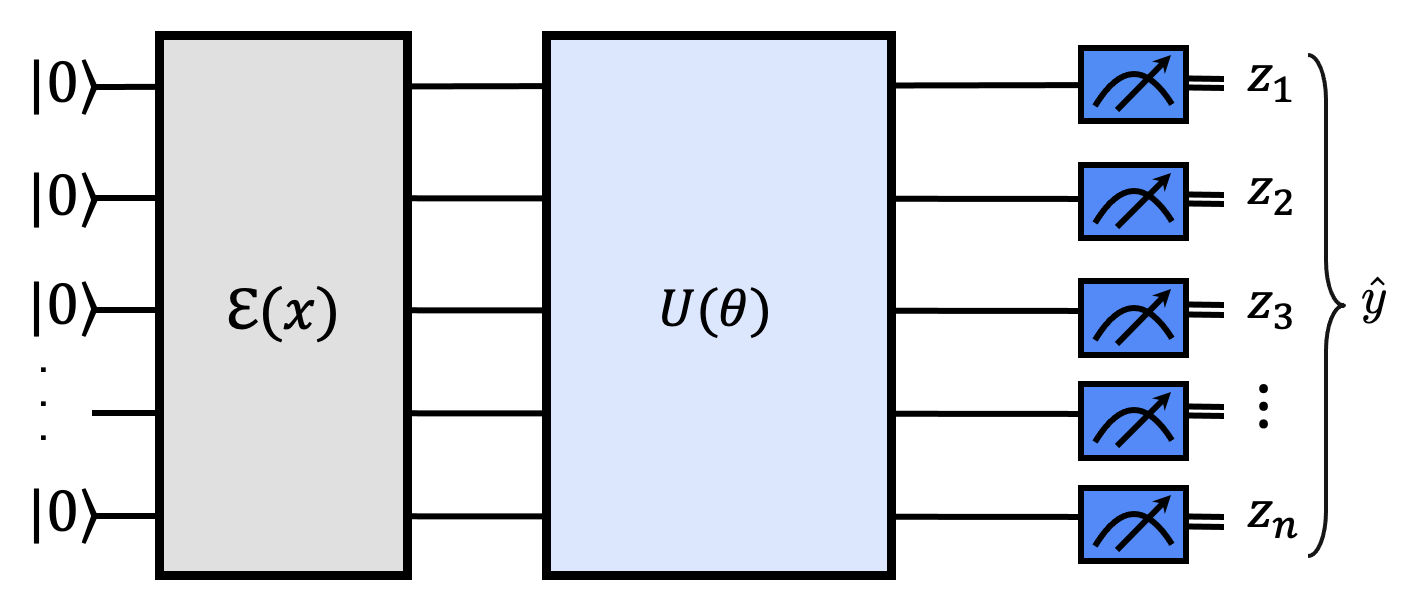
</div>
</center>

#### Let's walk through these blocks step by step

<div>
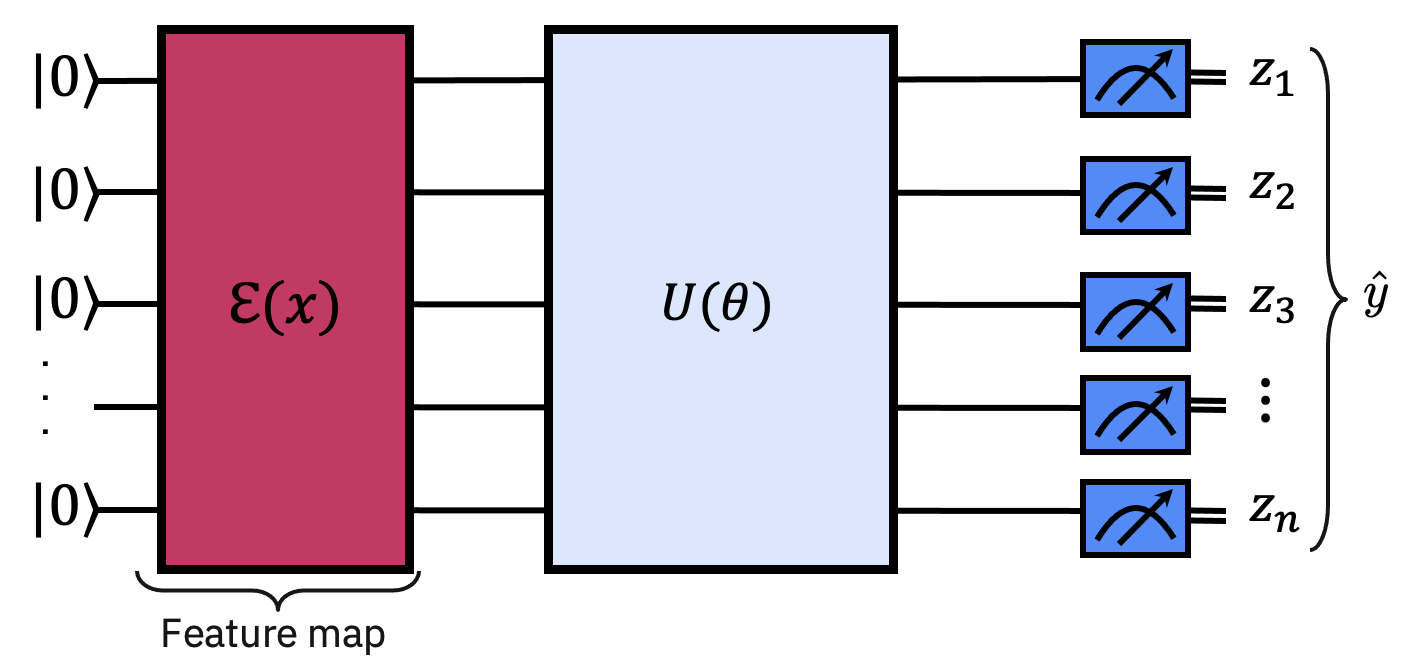
</div>

The first block is the feature encoding we already know, remember:
* Basis encoding
* Amplitude encoding
* Angle encoding

<div>
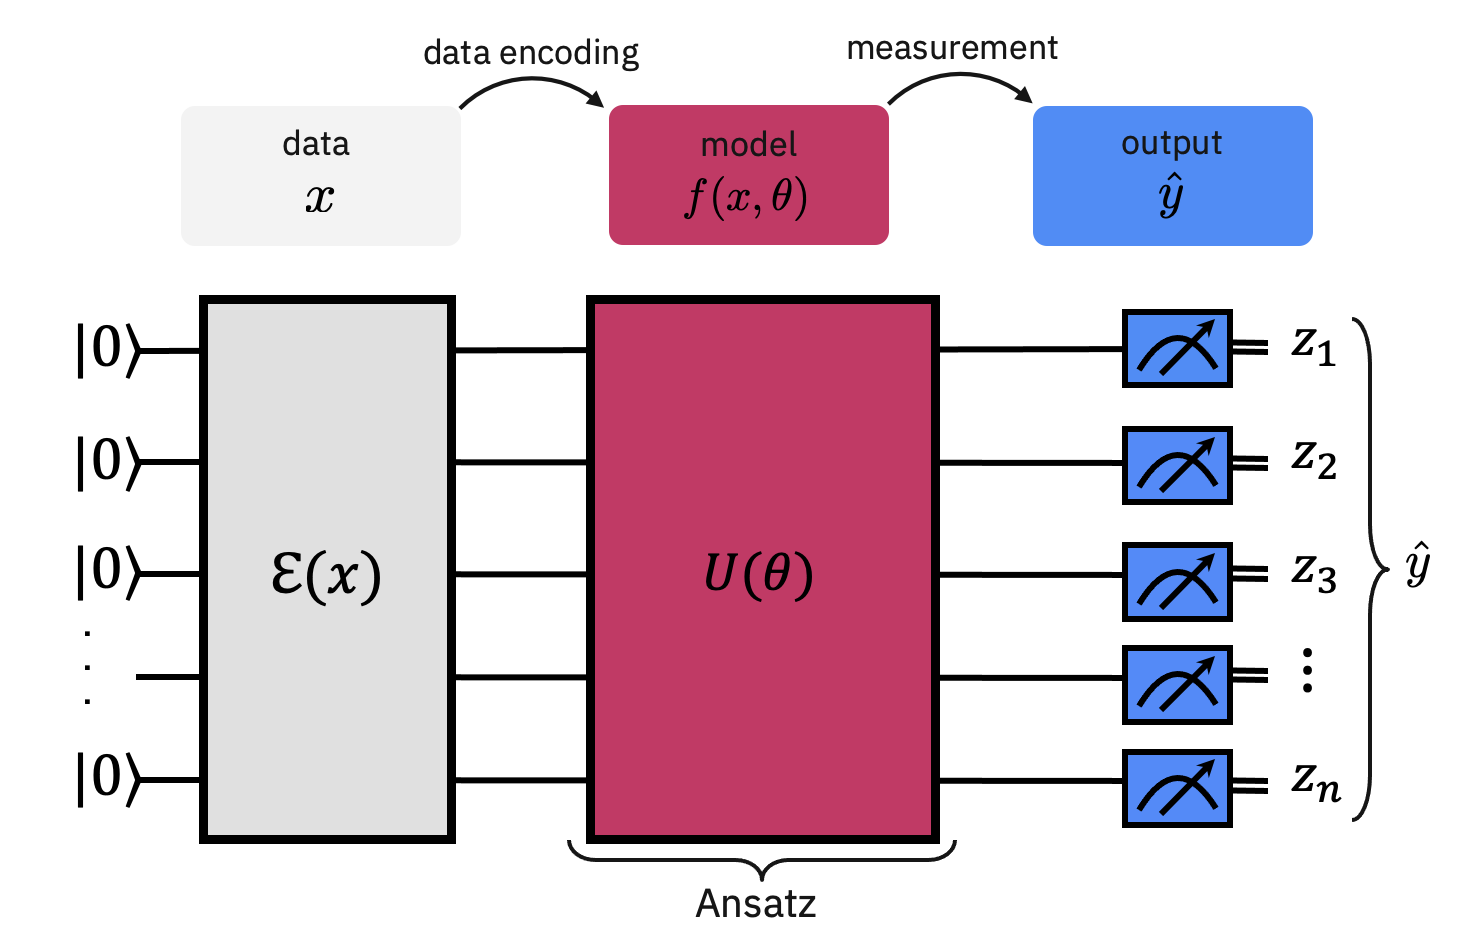
</div>

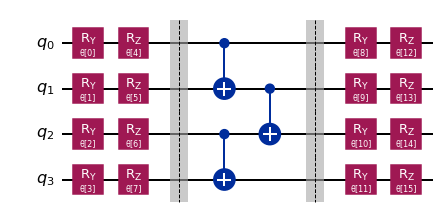

In [29]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(num_qubits=4, reps=1, entanglement="pairwise", insert_barriers=True)
ansatz.decompose().draw("mpl", style="iqx")

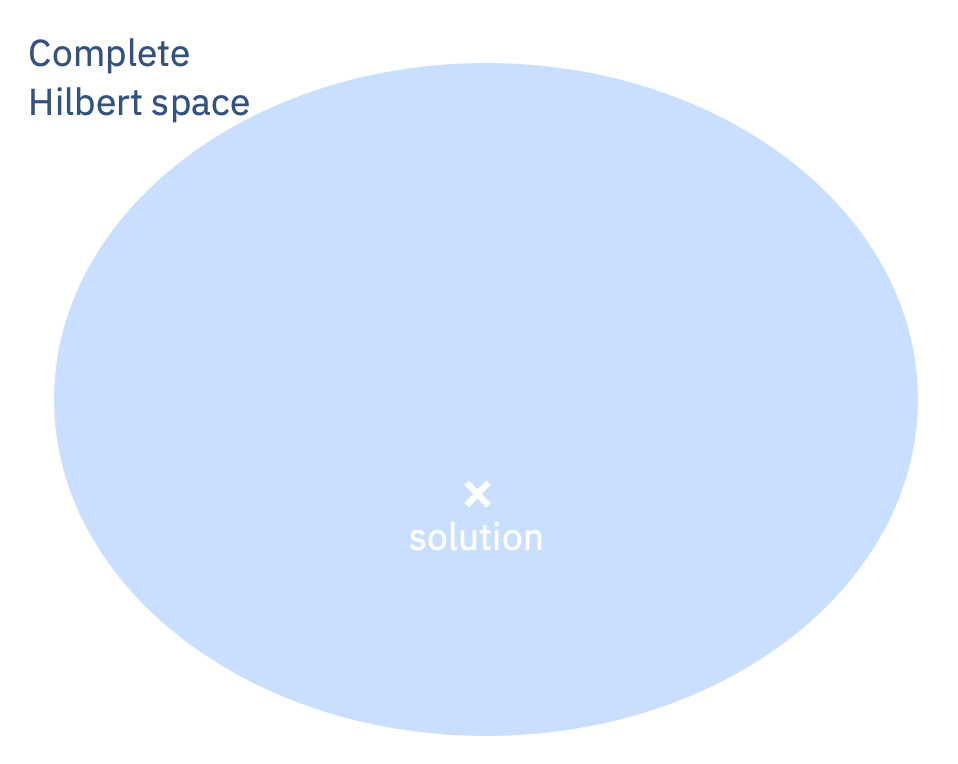

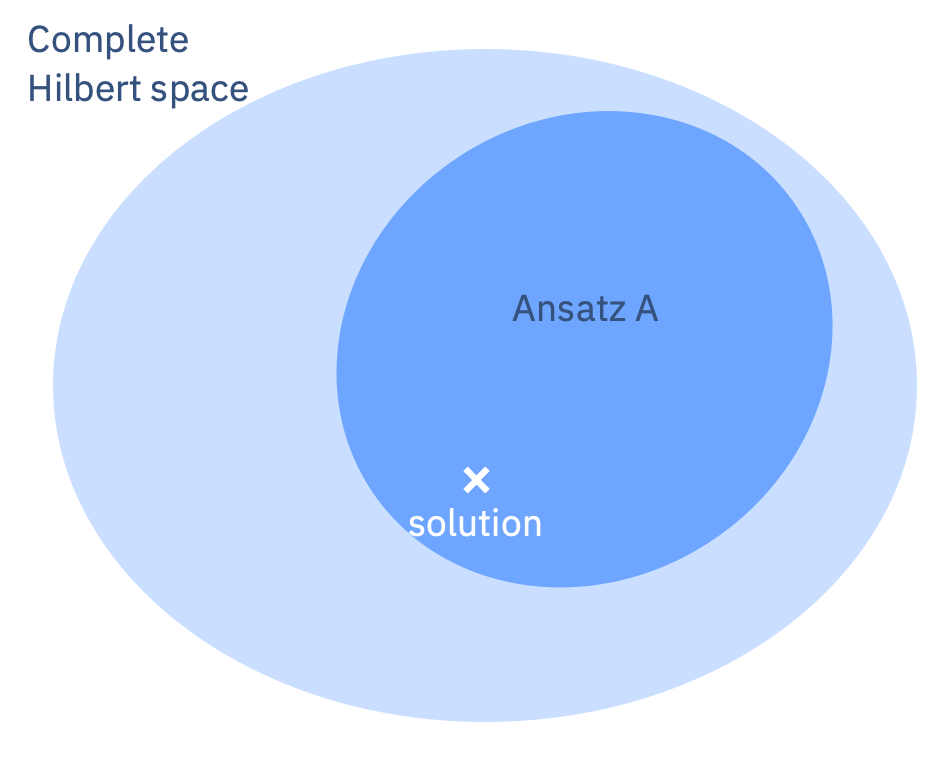

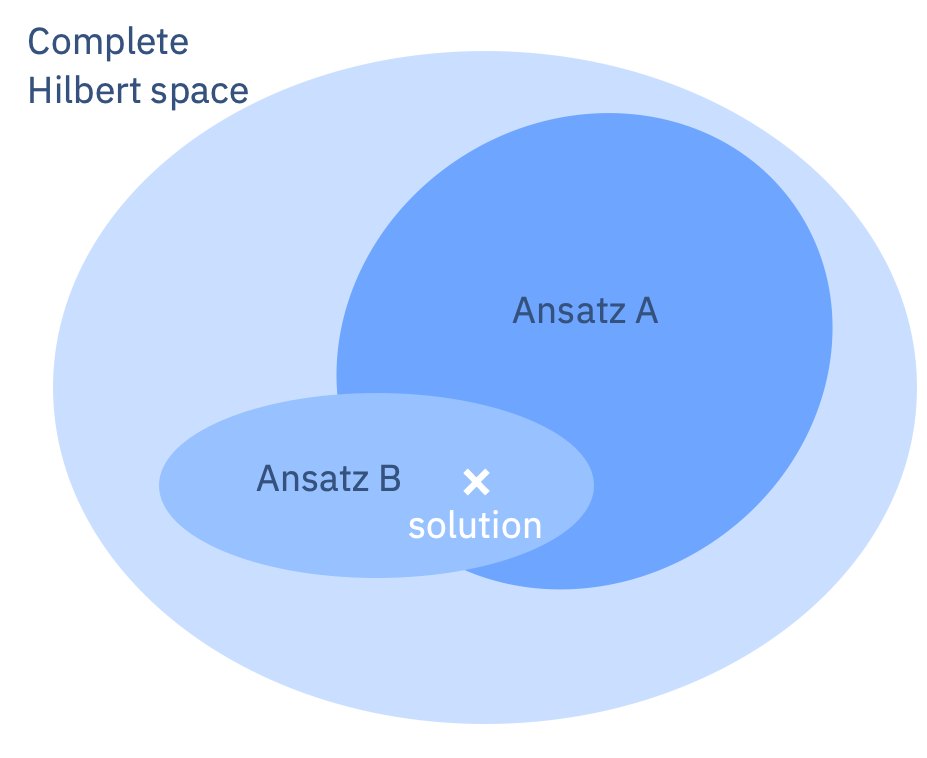

#### Heuristic vs. more problem-specific Ansatz

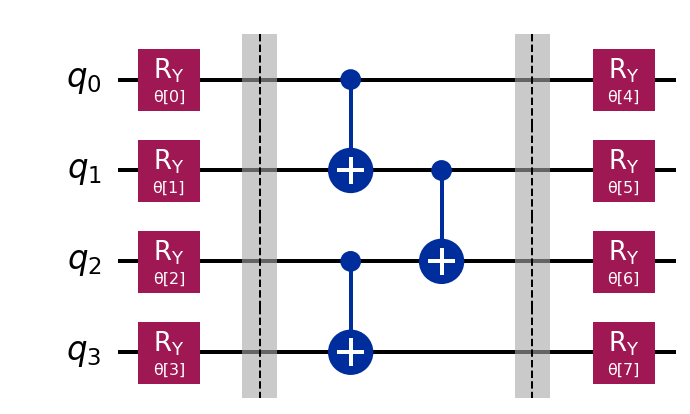

In [68]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=4, reps=1, entanglement="pairwise", insert_barriers=True)
ansatz.decompose().draw("mpl", style="iqx", scale=2)

<div>
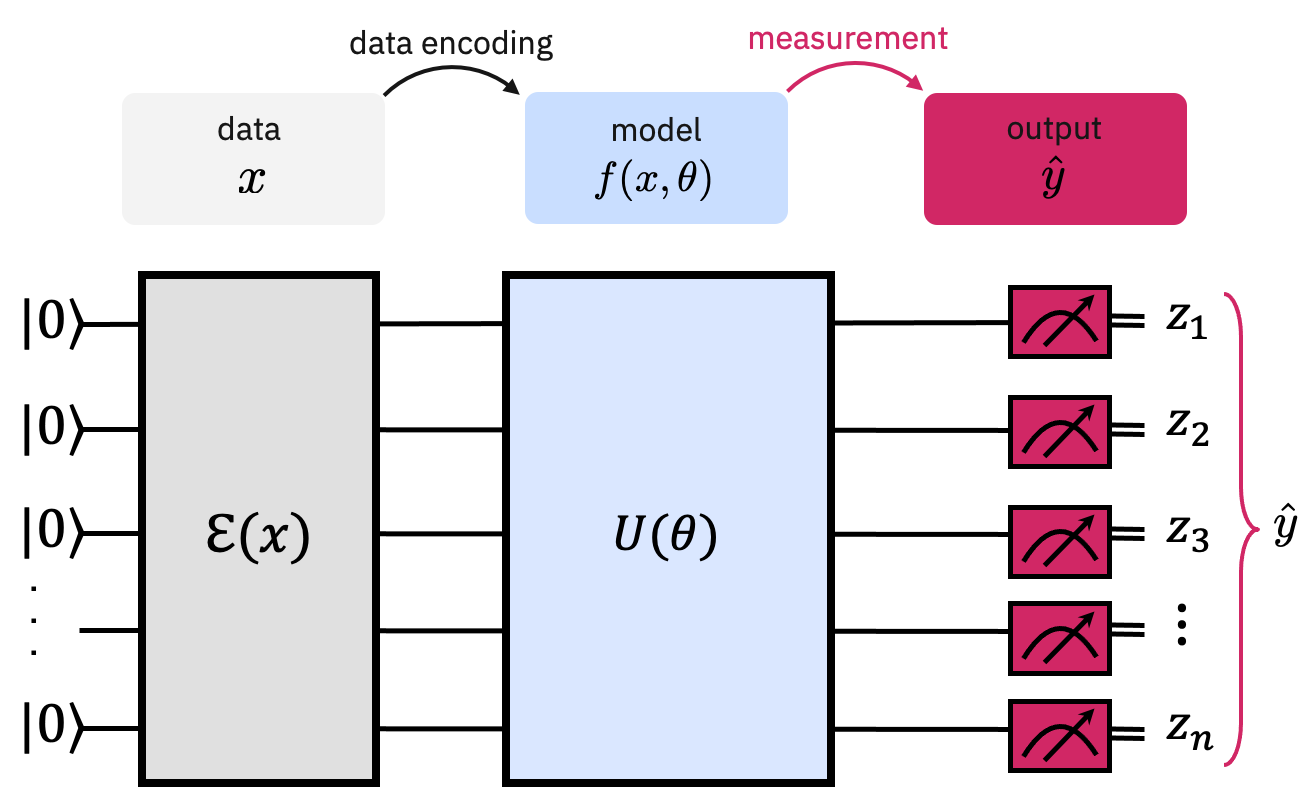
</div>

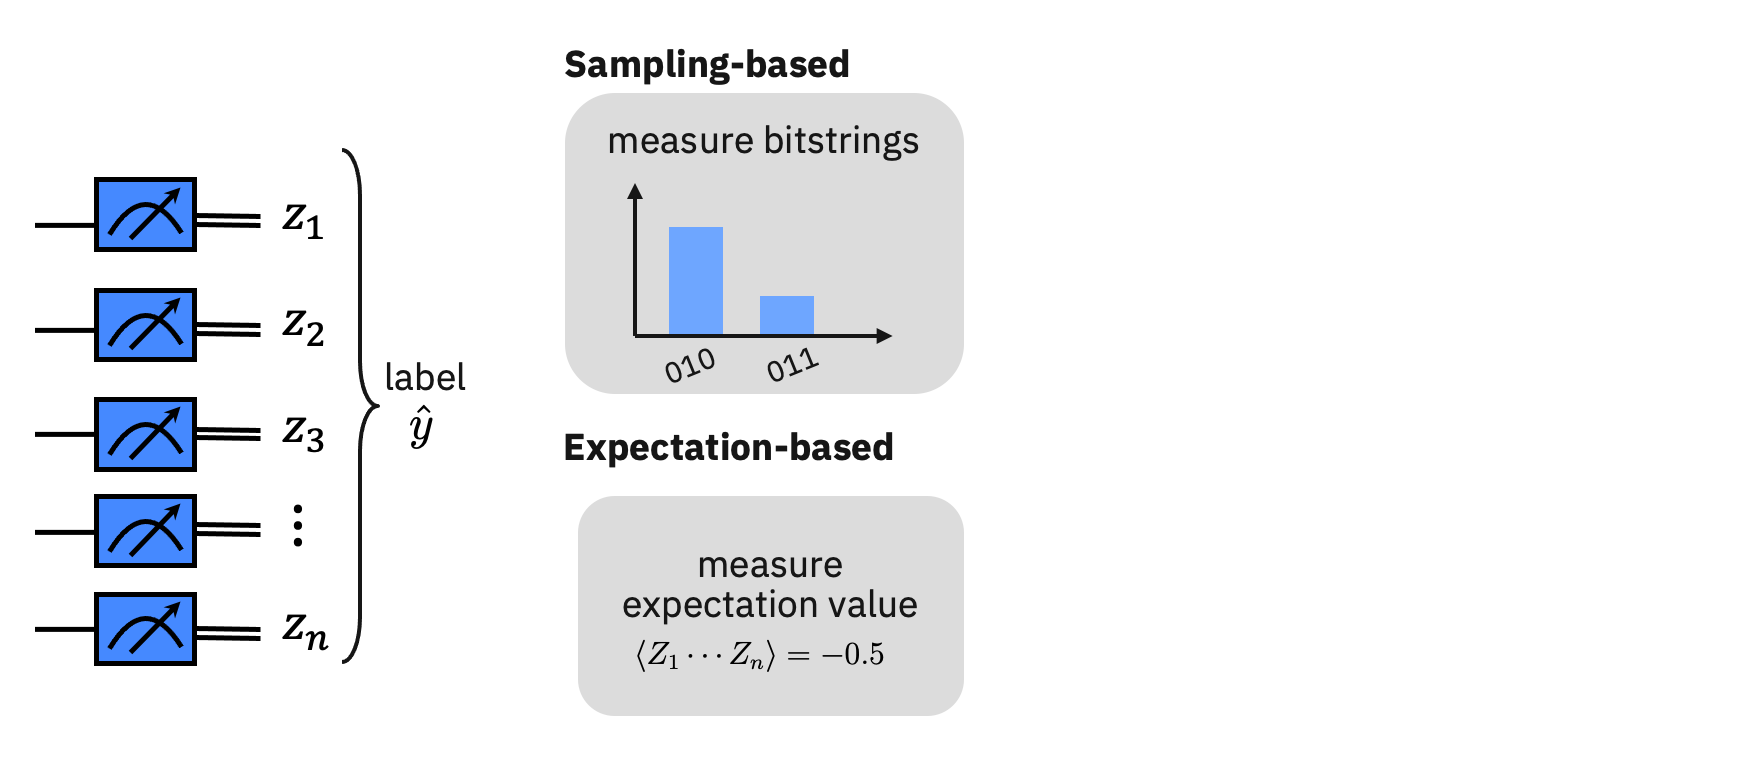

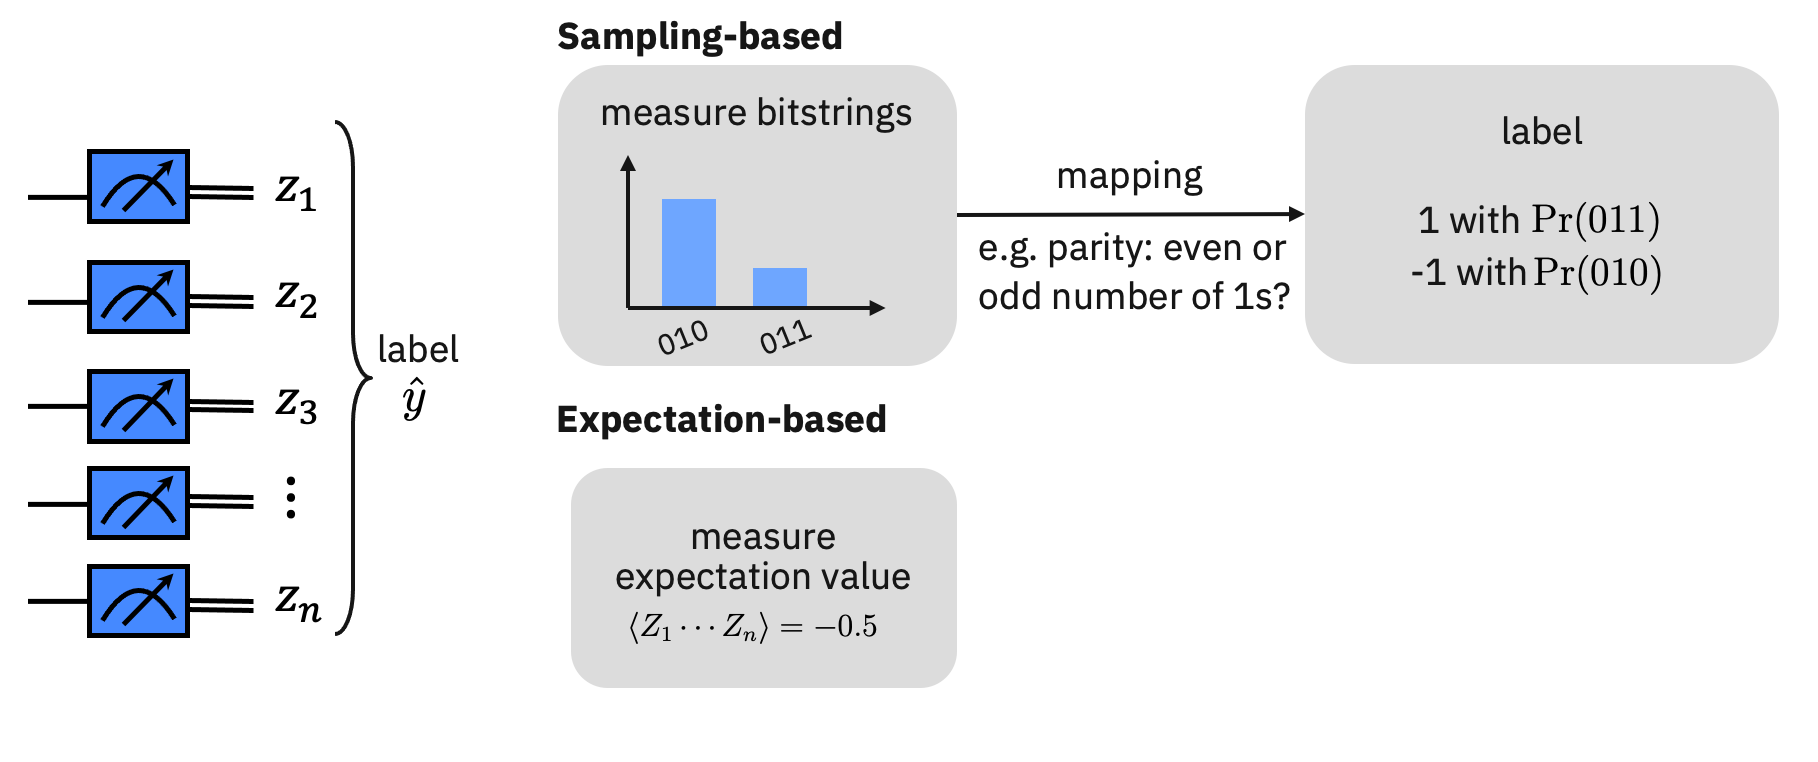

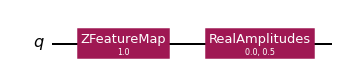

In [31]:
from qiskit.circuit.library import ZFeatureMap, RealAmplitudes

num_features = 1

feature_map = ZFeatureMap(num_features)
model = RealAmplitudes(num_features, reps=1, entanglement="pairwise")

circuit = feature_map.compose(model)

data = np.array([1])
angles = np.arange(model.num_parameters) / model.num_parameters
bound = circuit.bind_parameters(np.concatenate((data, angles)))

bound.draw("mpl", style="iqx", scale=2)

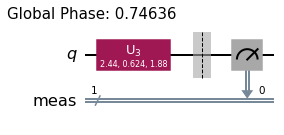

In [32]:
bound.measure_all()

backend = BasicAer.get_backend("qasm_simulator")
transpiled = transpile(bound, backend)

transpiled.draw("mpl", style="iqx", scale=2)

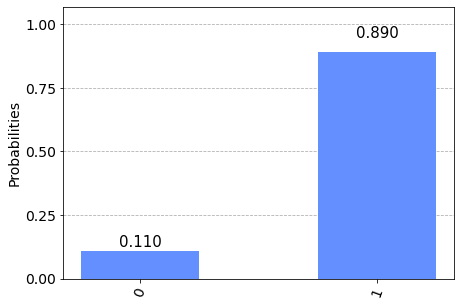

In [33]:
from qiskit.visualization import plot_histogram

result = backend.run(transpiled, shots=1000).result()
counts = result.get_counts()

plot_histogram(counts)

In [34]:
def parity(bitstring):
    # return 1 if there's an even number of 1's, otherwise return -1
    return 1 if bitstring.count("1") % 2 else -1

labels = {parity(bitstring): count / 1000 for bitstring, count in counts.items()}
print(labels)

{1: 0.89, -1: 0.11}


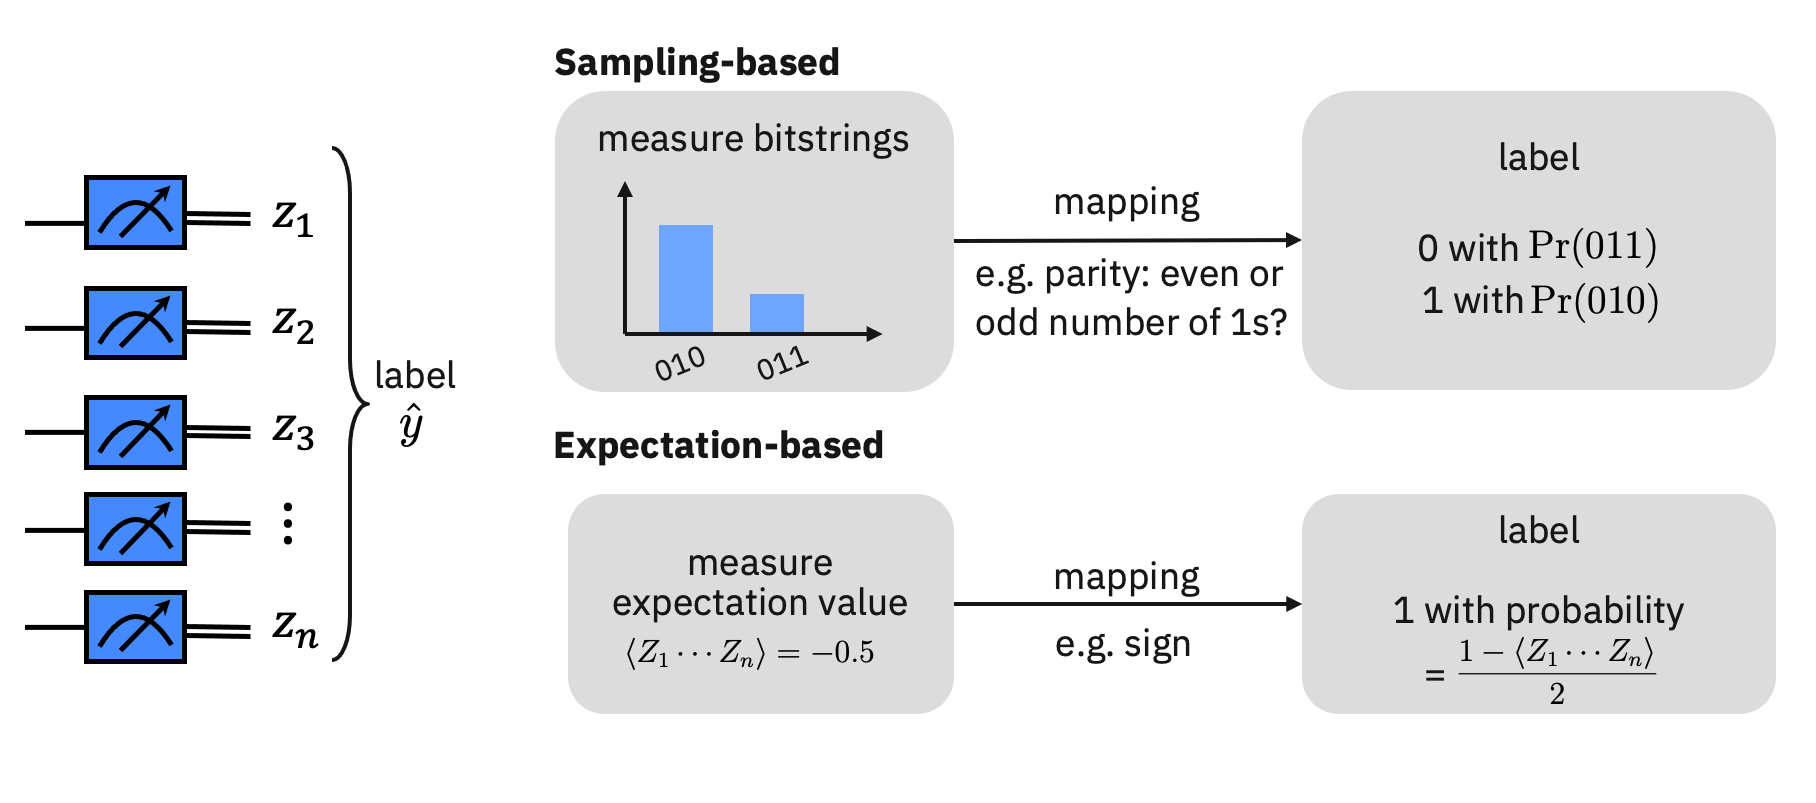

In [35]:
from qiskit.opflow import Z, StateFn, PauliExpectation, CircuitSampler

sampler = CircuitSampler(backend)  # this executes the circuits

bound = circuit.bind_parameters(np.concatenate((data, angles)))
expectation = StateFn(Z, is_measurement=True) @ StateFn(bound)
expectation_value = sampler.convert(PauliExpectation().convert(expectation)).eval().real

print(expectation_value)

-0.7265625000000001


In [36]:
probability_for_1 = (1 - expectation_value) / 2

expectation_labels = {1: probability_for_1, -1: 1 - probability_for_1}
print(expectation_labels)

{1: 0.86328125, -1: 0.13671875}


### Computing the loss

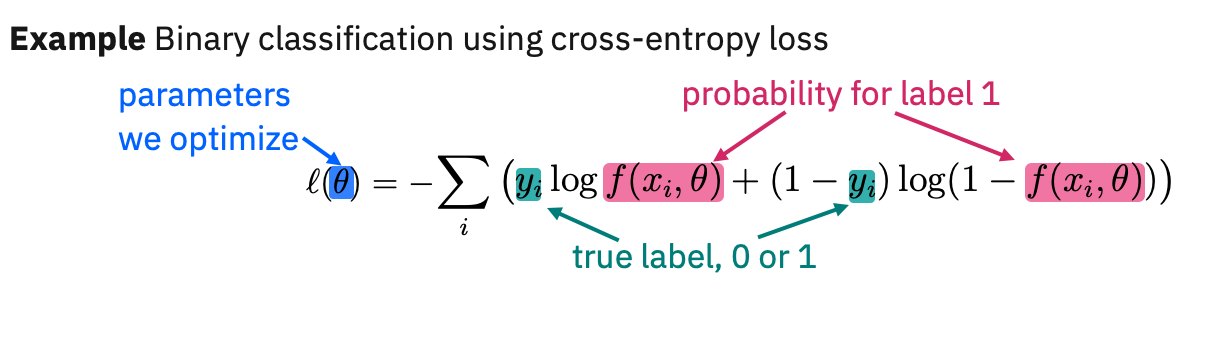

Text(0, 0.5, '$x_2$')

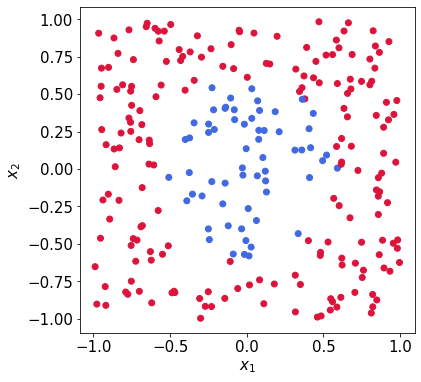

In [37]:
points, labels = circle()
colors = ["crimson" if label == 1 else "royalblue" for label in labels]

plt.figure(figsize=(6, 6))
plt.scatter(points[:, 0], points[:, 1], color=colors)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

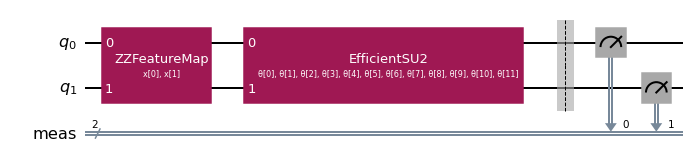

In [38]:
num_features = 2

feature_map = ZZFeatureMap(num_features, reps=3)
model = EfficientSU2(num_features, reps=2, entanglement="pairwise")

circuit = feature_map.compose(model)
circuit.measure_all()
circuit.draw("mpl", style="iqx")

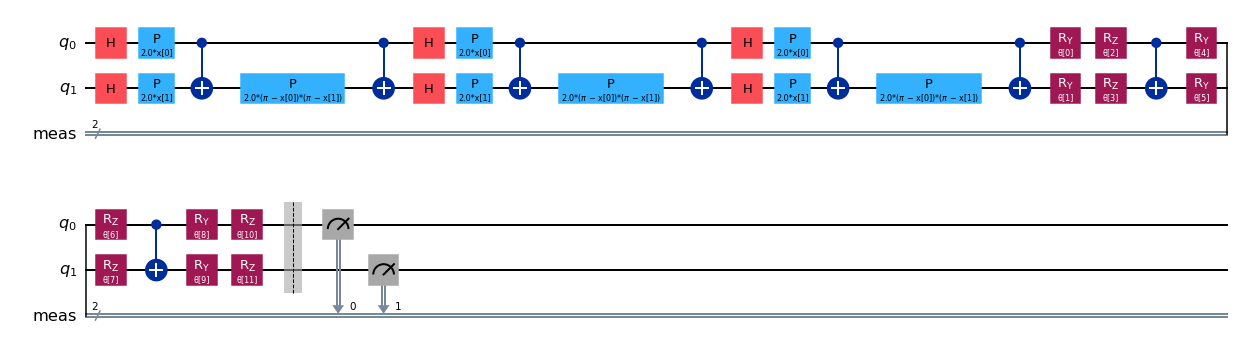

In [39]:
circuit.decompose().draw("mpl", style="iqx")

In [40]:
backend = BasicAer.get_backend("qasm_simulator")
transpiled = transpile(circuit, backend)
shots = 1000

def predict(theta, point, return_probabilities=False):
    bound = transpiled.assign_parameters(np.concatenate((point, theta)))
    
    counts = backend.run(bound, shots=shots).result().get_counts()
    
    pr_1 = 0
    for bitstr, count in counts.items():
        if parity(bitstr) == 1:
            pr_1 += count / shots
            
    if return_probabilities:
        return pr_1
    
    return 1 if pr_1 > 0.5 else 0

In [41]:
cutoff = 1e-10
def safe_log(value):
    return np.log(max(cutoff, value))

def loss(theta, X, y):
    loss_value = 0
    for X_i, y_i in zip(X, y):
        # probabilities for the predicted labels to be 1
        pr_1 = predict(theta, X_i, return_probabilities=True)
        loss_value -= y_i * safe_log(pr_1) + (1 - y_i) * safe_log(1 - pr_1)
            
    return loss_value

In [42]:
from qiskit.algorithms.optimizers import COBYLA

In [43]:
one_zero_labels = (1 + np.array(labels)) / 2  # cross-entropy expects labels in {0, 1}!

cost = lambda theta: loss(theta, points.tolist(), one_zero_labels.tolist())
result = COBYLA().minimize(cost, x0=np.random.random(model.num_parameters))

In [44]:
predictions = [predict(result.x, X_i) for X_i in points.tolist()]

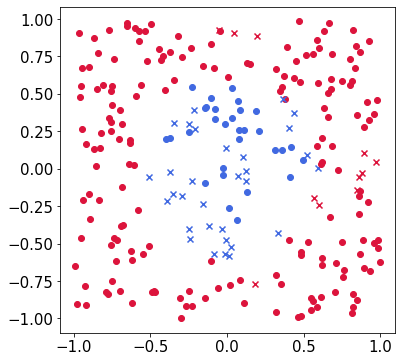

In [45]:
markers = ["o" if label == predicted_label else "x" for label, predicted_label in zip(one_zero_labels, predictions)]
plt.figure(figsize=(6, 6))
for point, marker, color in zip(points.tolist(), markers, colors):
    plt.scatter(point[0], point[1], color=color, marker=marker)

### Use Qiskit instead of our manual coding!

In [46]:
from qiskit_machine_learning.algorithms import VQC

vqc = VQC(2, feature_map, model, quantum_instance=backend)

In [47]:
# one hot encoding: 1 -> [1, 0] and -1 -> [0, 1]
one_hot = np.array([[1, 0] if label == 1 else [0, 1] for label in labels])
vqc.fit(points, one_hot)

In [48]:
vqc_predictions = vqc.predict(points)

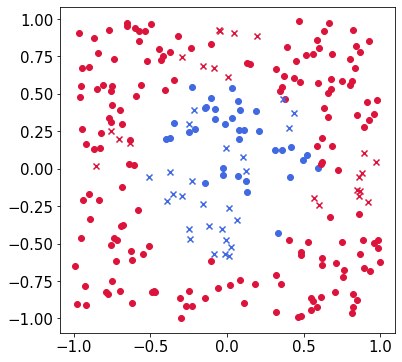

In [49]:
markers = ["o" if label == predicted_label else "x" for label, predicted_label in zip(labels, 2 * vqc_predictions[:, 0] - 1)]
plt.figure(figsize=(6, 6))
for point, marker, color in zip(points.tolist(), markers, colors):
    plt.scatter(point[0], point[1], color=color, marker=marker)

Why are the classifications not perfect?

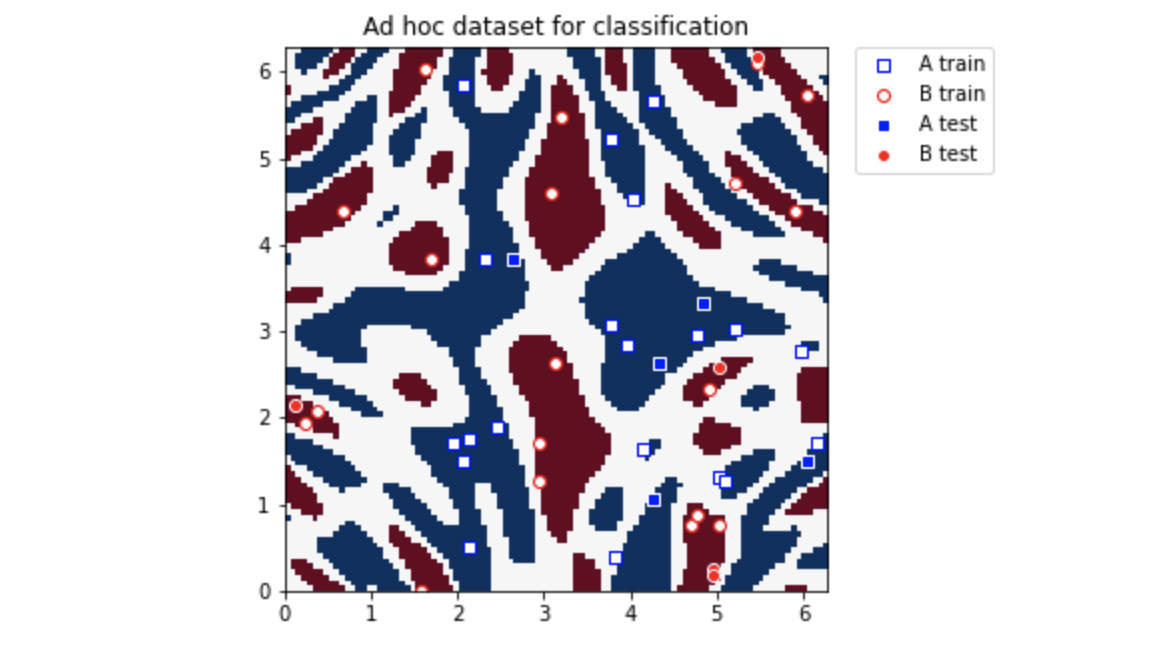

See `qiskit_machine_learning.datasets.ad_hoc_data` for the generation.

#### How could we optimize more efficiently?

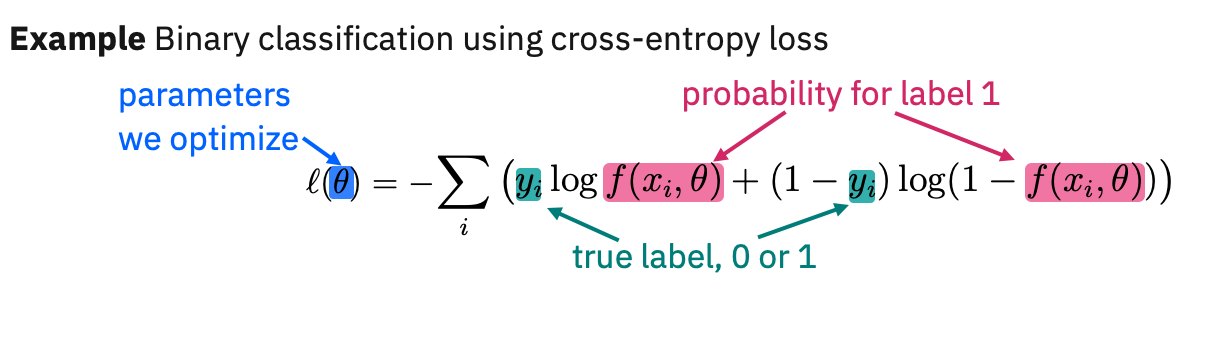

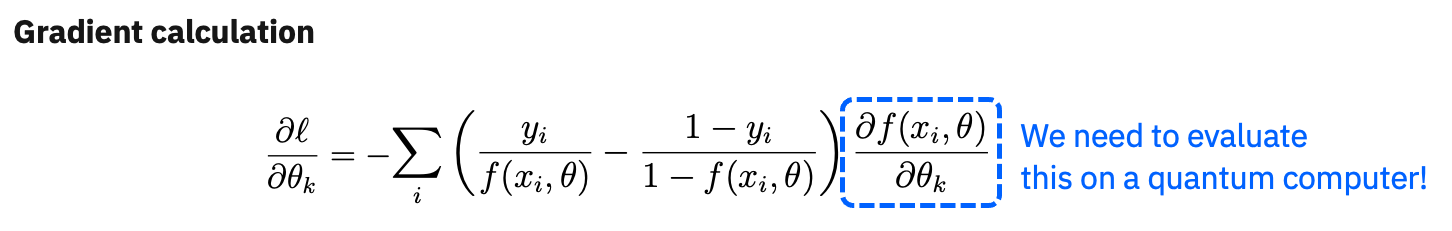

$\rightarrow$ see Christa's lectures!

# Machine Learning with Qiskit

Algorithms in Qiskit's Machine Learning module have the same, simple structure:

```python
from qiskit_machine_learning.algorithms import Algorithm

algo = Algorithm(settings)
algo.fit(X, y)
y_hat = algo.predict(X)
```

For example, we've already seen the Quantum Support Vector Classifier (QSVC):
```python
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.algorithms import QSVC

kernel = QuantumKernel(feature_map, quantum_instance=backend)

algo = QSVC(kernel)
algo.fit(X, y)
y_hat = algo.predict(X)
```

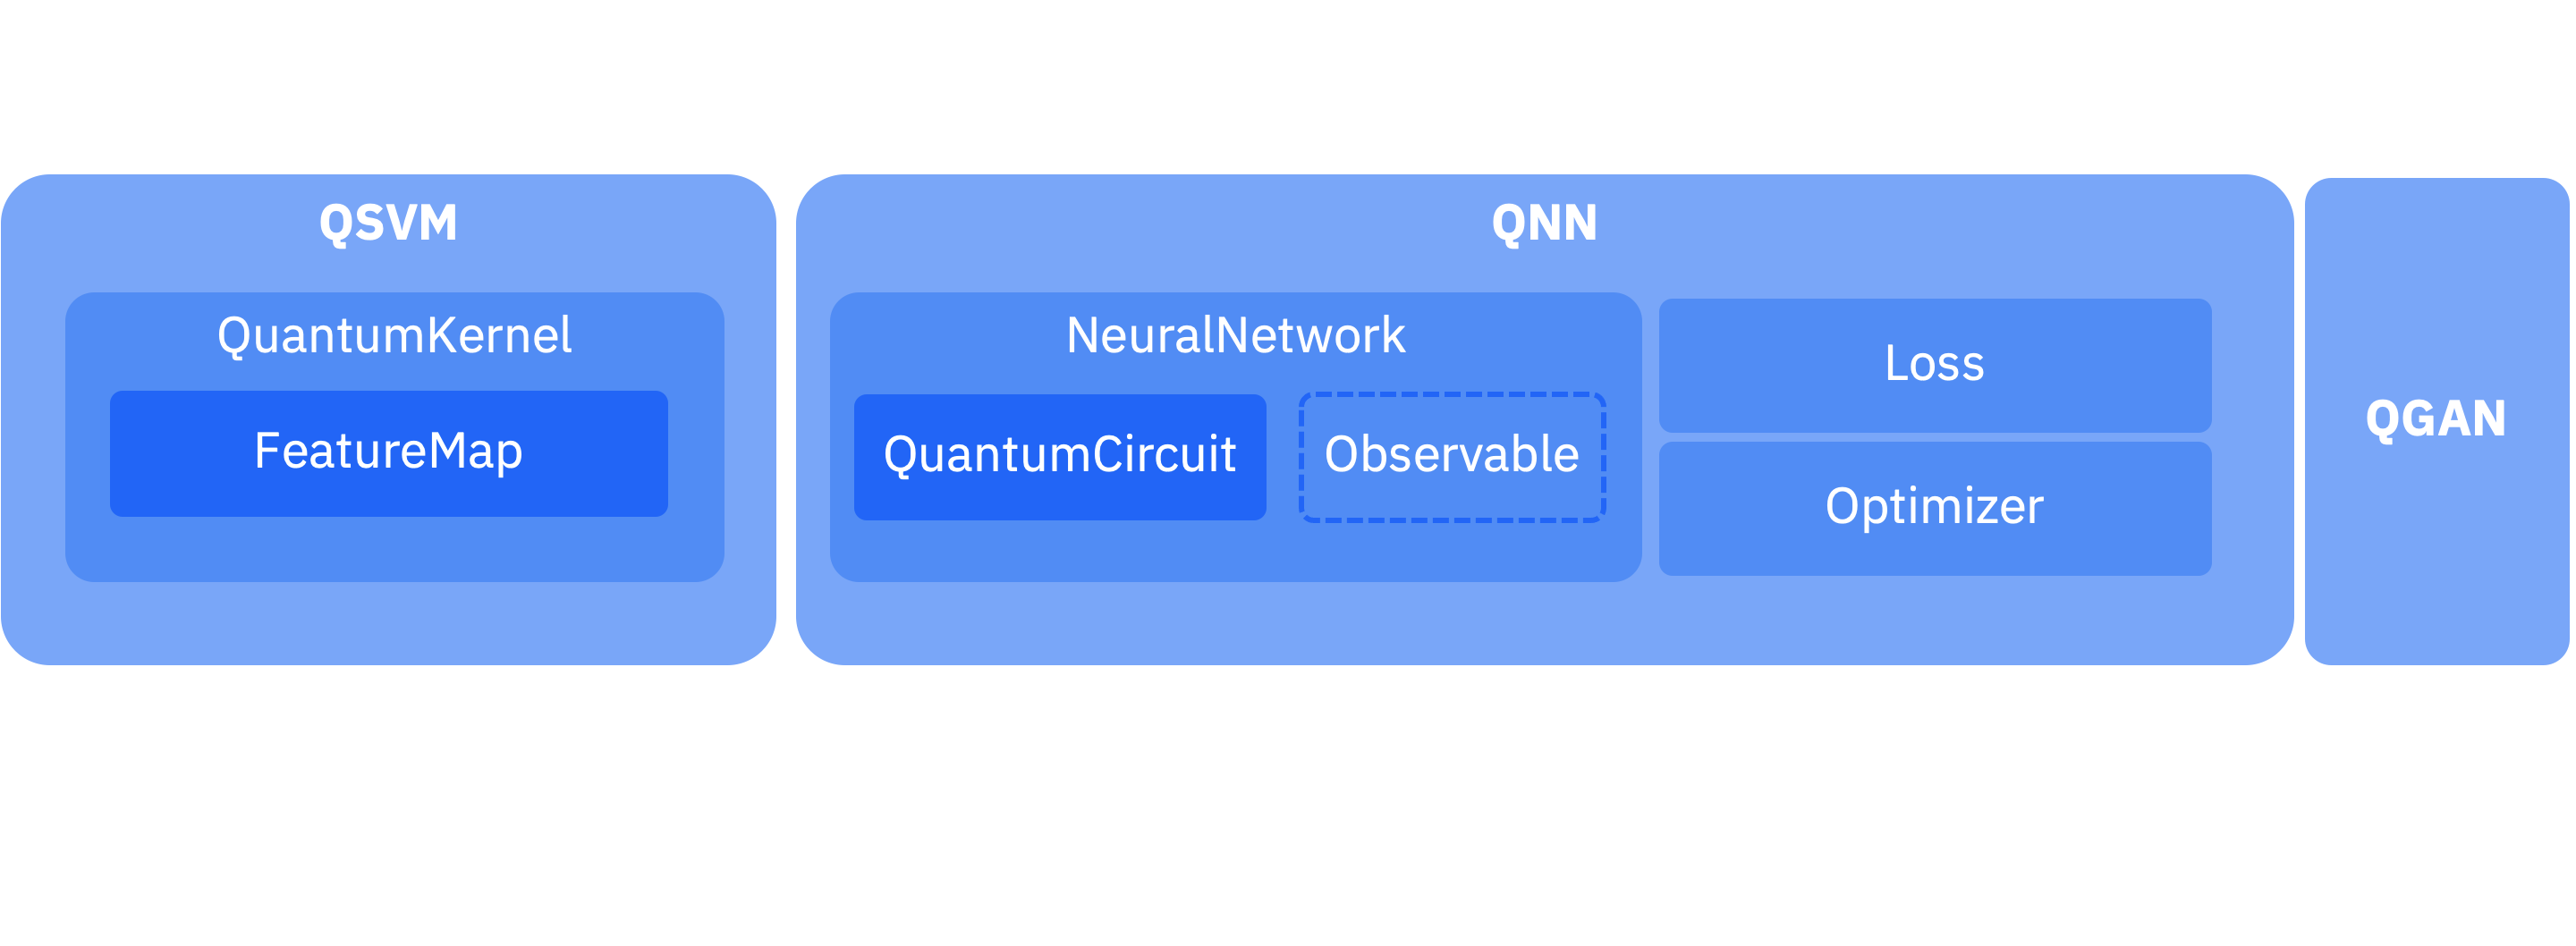

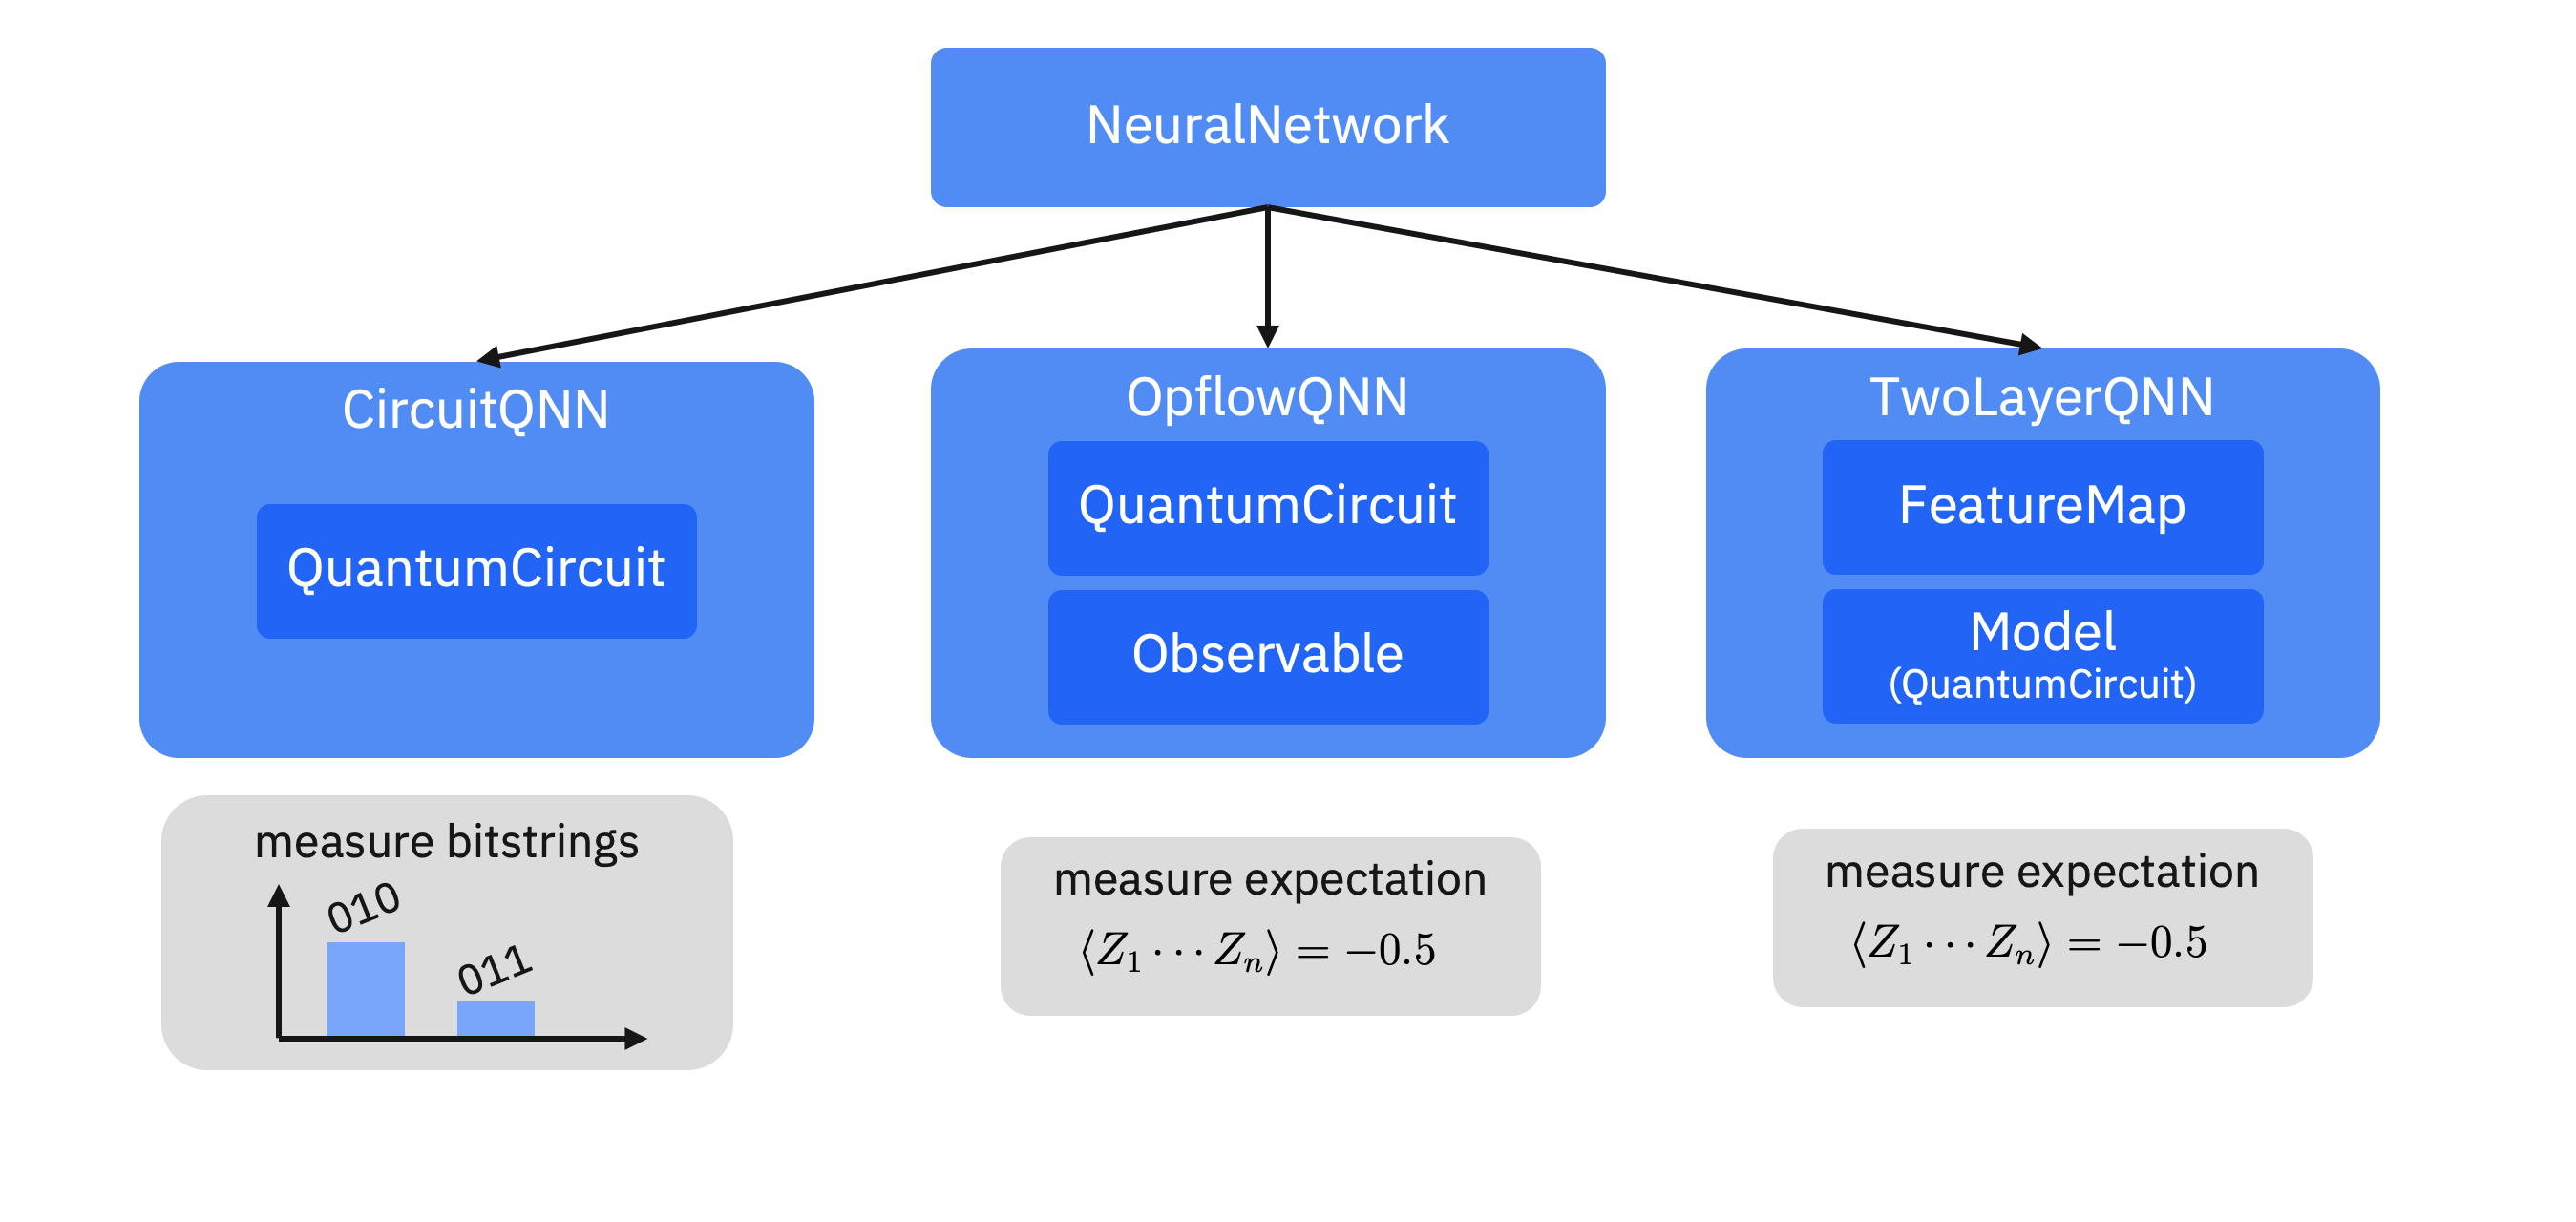

### Plan

1. Regression with an ``OpflowQNN``
2. Integration with ``PyTorch``

### Regression

From [1] we know that circuits are pretty good at representing data from a partial Fourier series.

[1]: _Schuld et al. "The effect of data encoding on the expressive power of variational quantum machine learning models" Phys. Rev. A 103, 032430 (2021)_

In [69]:
def generate_waveline(num_points):
    x = np.linspace(0.5, 0.5 + 2 * np.pi, num_points)        
    y = 0.3 * np.sin(x) + 0.4 * np.sin(2 * x) - 0.2 * np.sin(0.5 * x)
    
    return x.reshape((-1,1)), y

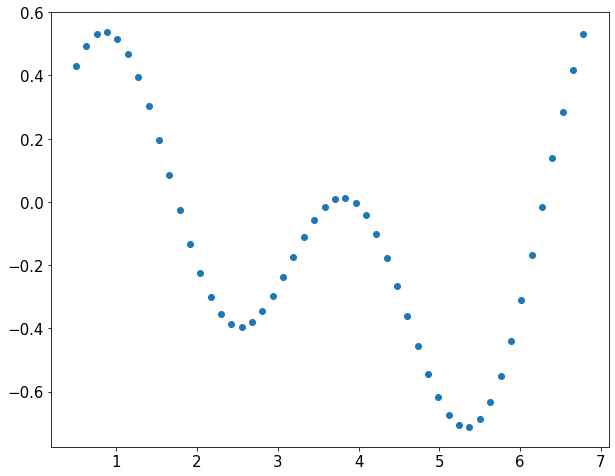

In [70]:
X, y = generate_waveline(50)

plt.figure(figsize=(10, 8))
plt.plot(X, y.real, "o")

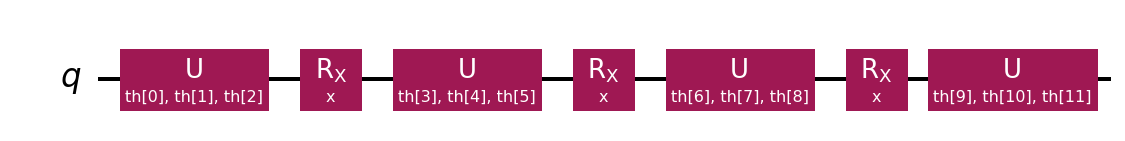

In [71]:
from qiskit.circuit import Parameter, ParameterVector

reps = 3
circuit = QuantumCircuit(1)
x = Parameter("x")
theta = ParameterVector("th", 3 * (reps + 1))

for i in range(reps):
    circuit.u(theta[3 * i], theta[3 * i + 1], theta[3 * i + 2], 0)
    circuit.rx(x, 0)
    
circuit.u(*theta[-3:], 0)

circuit.draw("mpl", style="iqx", scale=2)

In [72]:
from qiskit_machine_learning.neural_networks import OpflowQNN
from qiskit.opflow import Z, StateFn

expectation = StateFn(Z, is_measurement=True) @ StateFn(circuit)

qnn = OpflowQNN(expectation, input_params=[x], weight_params=list(theta), 
                quantum_instance=BasicAer.get_backend("statevector_simulator"))

In [74]:
from qiskit_machine_learning.algorithms import NeuralNetworkRegressor

loss_history = []
def store_loss(weights, loss_value):
    loss_history.append(loss_value)

regressor = NeuralNetworkRegressor(neural_network=qnn, optimizer=COBYLA(), loss="squared_error",
                                   callback=store_loss)

In [75]:
regressor.fit(X, y)

In [76]:
y_hat = regressor.predict(X)

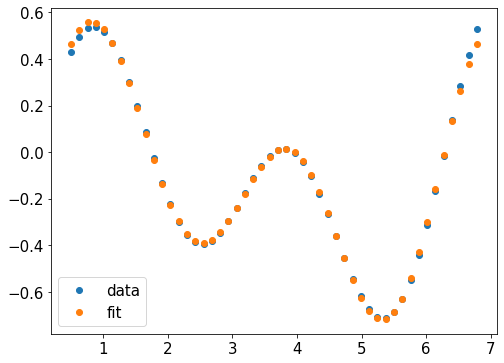

In [77]:
plt.figure(figsize=(8, 6))
plt.plot(X, y, "o", label="data")
plt.plot(X, y_hat, "o", label="fit")
plt.legend(loc="best")

Text(0.5, 0, 'function evaluations')

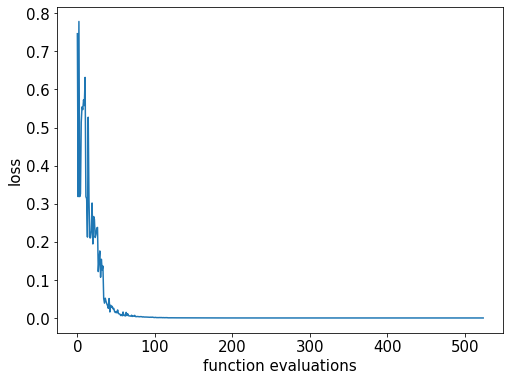

In [78]:
plt.figure(figsize=(8, 6))
plt.plot(loss_history)
plt.ylabel("loss")
plt.xlabel("function evaluations")

### Integration with PyTorch

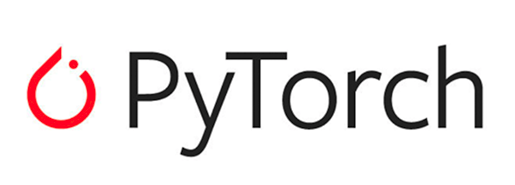

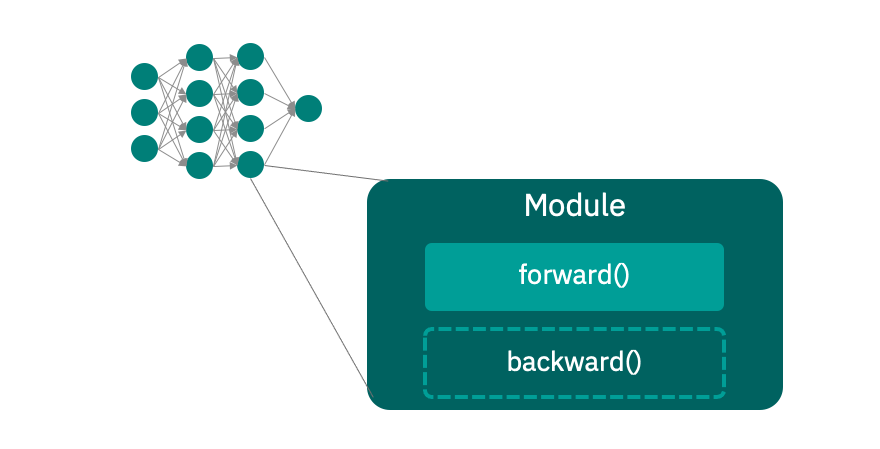

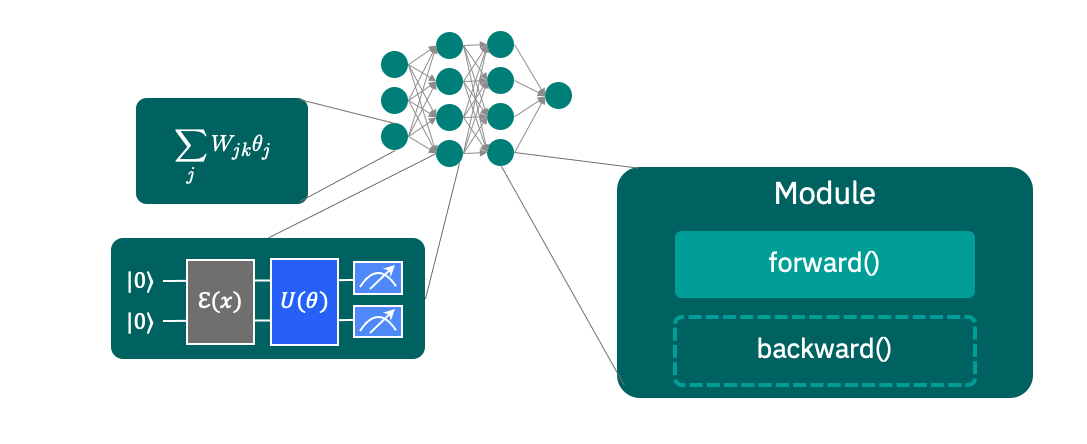

In [79]:
# Select dataset dimension (num_inputs) and size (num_samples)
num_inputs = 2
num_samples = 20

# Generate random input coordinates (X) and binary labels (y)
X = 2 * np.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}, y01 will be used for CircuitQNN example
y = 2 * y01 - 1  # in {-1, +1}, y will be used for OplowQNN example

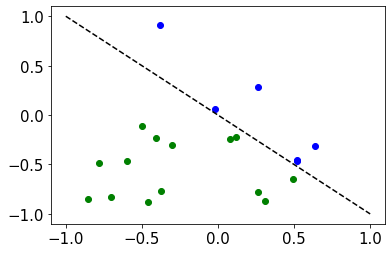

In [80]:
from torch import Tensor

# Convert to torch Tensors
X_ = Tensor(X)
y01_ = Tensor(y01).reshape(len(y)).long()
y_ = Tensor(y).reshape(len(y), 1)

# Plot dataset
for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.plot([-1, 1], [1, -1], "--", color="black")

In [81]:
from qiskit_machine_learning.neural_networks import TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

qnn = TwoLayerQNN(num_qubits=num_inputs, quantum_instance=BasicAer.get_backend("statevector_simulator"))

# Set up PyTorch module
initial_weights = 0.1 * (2 * np.random.random(qnn.num_weights) - 1)
model = TorchConnector(qnn, initial_weights=initial_weights)
print("Initial weights: ", initial_weights)

Initial weights:  [-0.01391729 -0.09350296  0.00633928  0.01791063 -0.0337127  -0.06281162
 -0.03498449  0.03697282]


In [82]:
from torch.nn import MSELoss
from torch.optim import LBFGS

# Define optimizer and loss
optimizer = LBFGS(model.parameters())
f_loss = MSELoss(reduction="sum")

# Start training
model.train()  # set model to training mode

TorchConnector()

In [83]:
def closure():
    optimizer.zero_grad()  # Initialize/clear gradients
    loss = f_loss(model(X_), y_)  # Evaluate loss function
    loss.backward()  # Backward pass
    return loss

for _ in range(100):
    optimizer.step(closure)

Accuracy: 0.9


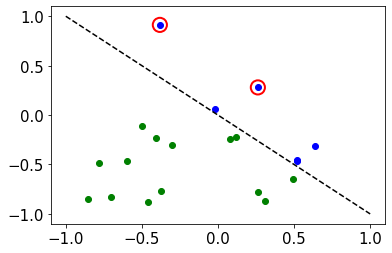

In [84]:
# Evaluate model and compute accuracy
y_predict = []
for x, y_target in zip(X, y):
    output = model(Tensor(x))
    y_predict += [np.sign(output.detach().numpy())[0]]

print("Accuracy:", sum(y_predict == y) / len(y))

# Plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")

### More tutorials

https://qiskit.org/documentation/machine-learning/tutorials

### Question? Contributions?

Qiskit Machine Learning on GitHub: https://github.com/Qiskit/qiskit-machine-learning

Qiskit Community Slack: https://ibm.co/joinqiskitslack

### Basis encoding

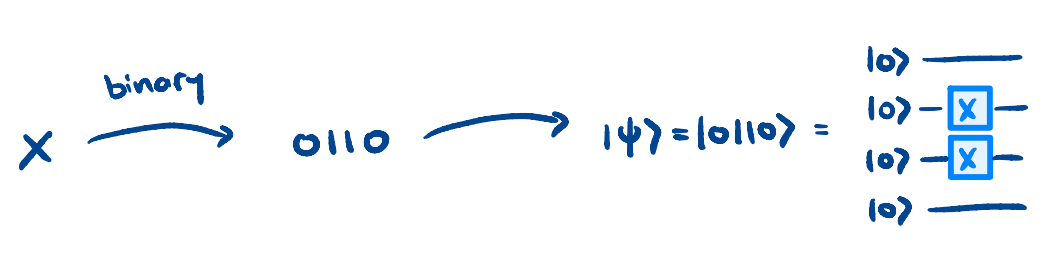

In [ ]:
x = 6
num_qubits = 4

x_binary = bin(x)[2:].zfill(num_qubits)
print(x_binary)

In [ ]:
from qiskit import QuantumCircuit

data = QuantumCircuit(num_qubits)
for i, bit in enumerate(x_binary):
    if bit == "1":
        data.x(i)
        
data.draw("mpl", style="iqx")

### Amplitude encoding

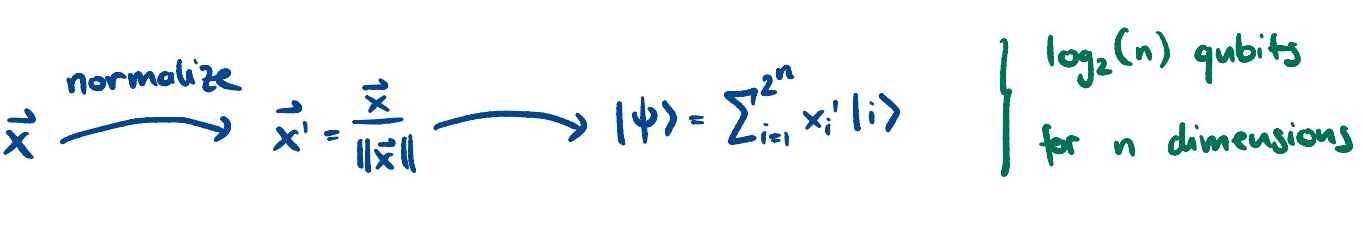

In [ ]:
from qiskit.circuit.library import StatePreparation

x = np.random.random(2 ** num_qubits)  # data must be 2^n dimensional (we can pad other cases with 0)
x_normalized = x / np.linalg.norm(x)

data = QuantumCircuit(num_qubits)
data.prepare_state(x_normalized)
data.draw("mpl", style="iqx")

In [ ]:
from qiskit import transpile

transpiled = transpile(data, basis_gates=["x", "sx", "rz", "cx"])
transpiled.draw("mpl", style="iqx")

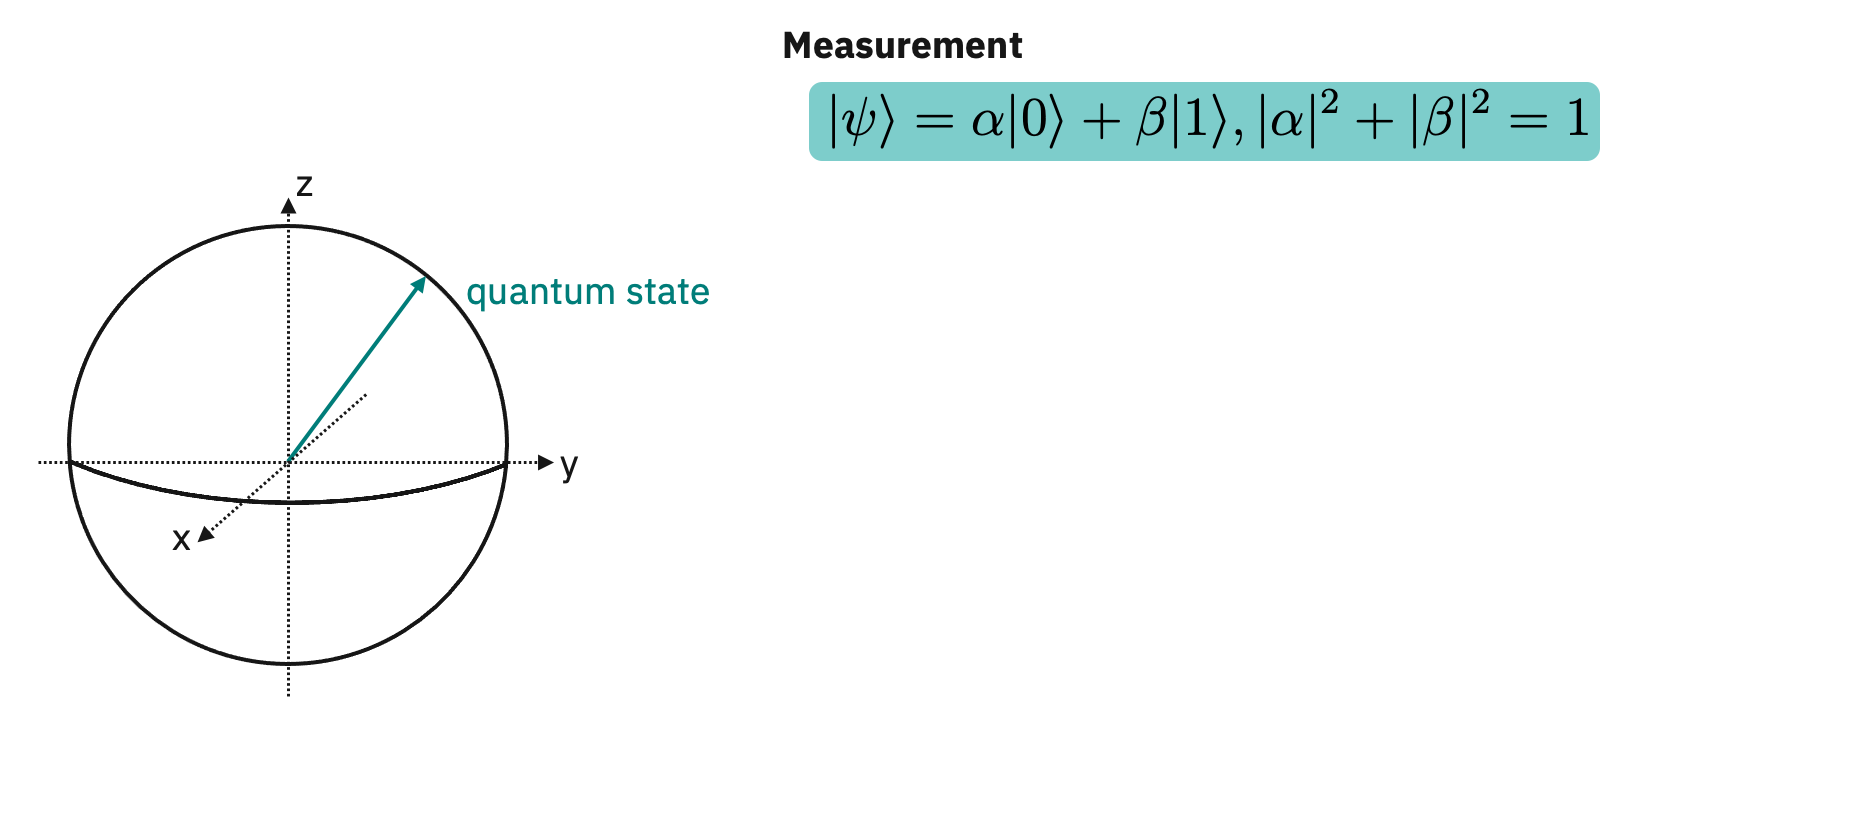

In [ ]:
from qiskit.quantum_info import Statevector

state = Statevector(bound)
print(state)

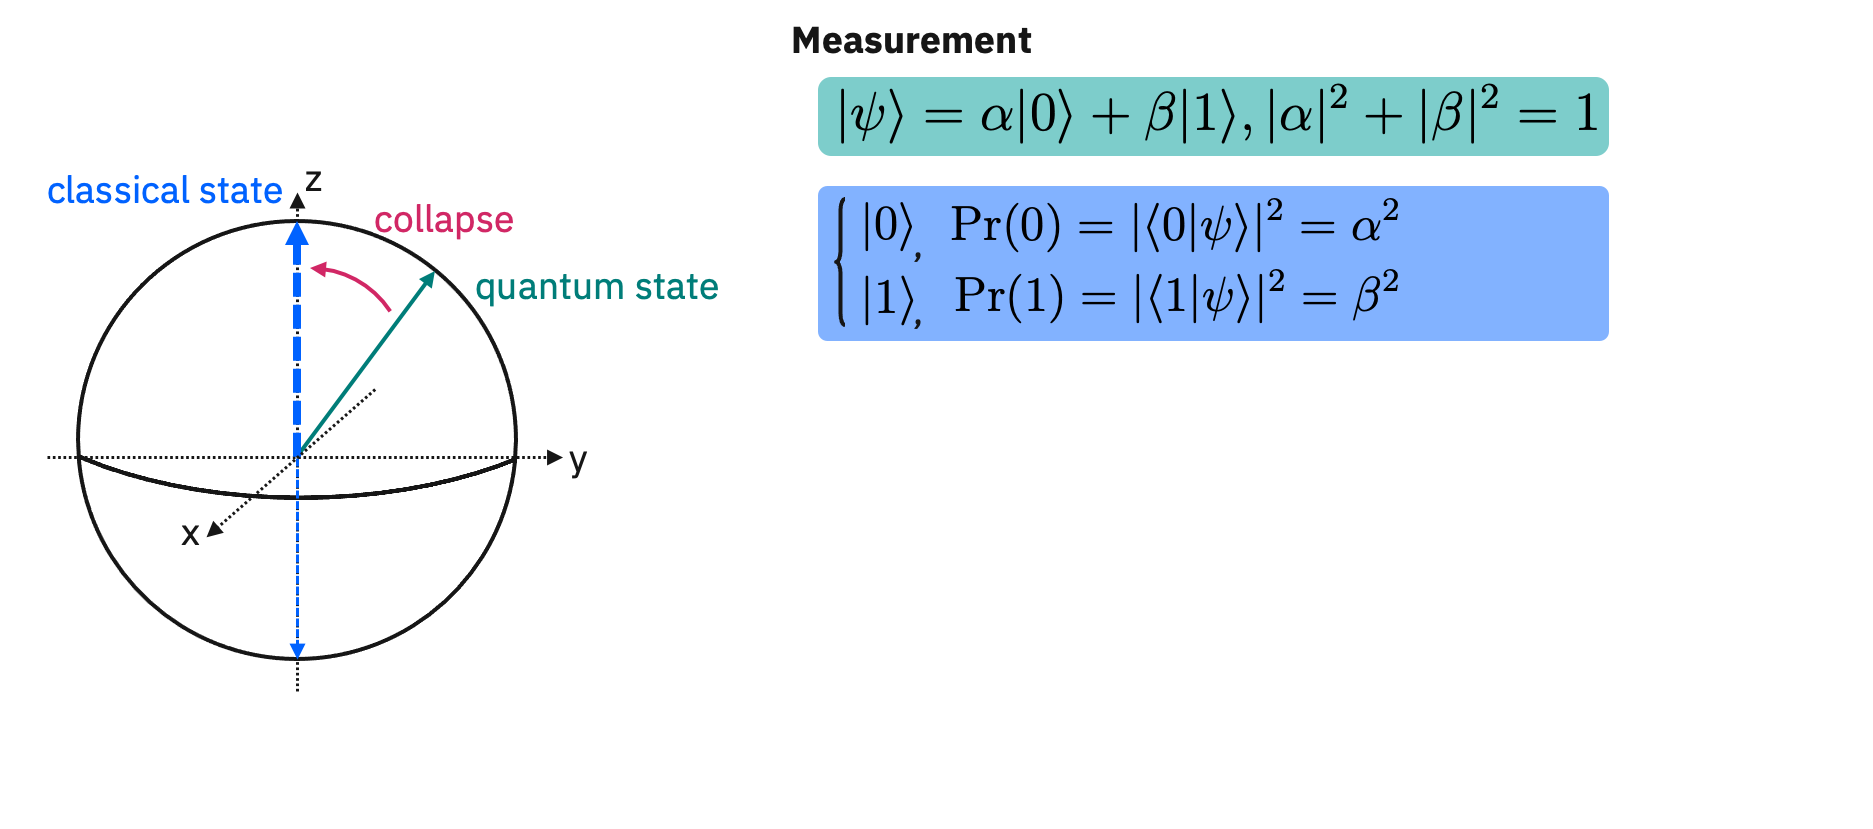

In [ ]:
state.probabilities_dict()

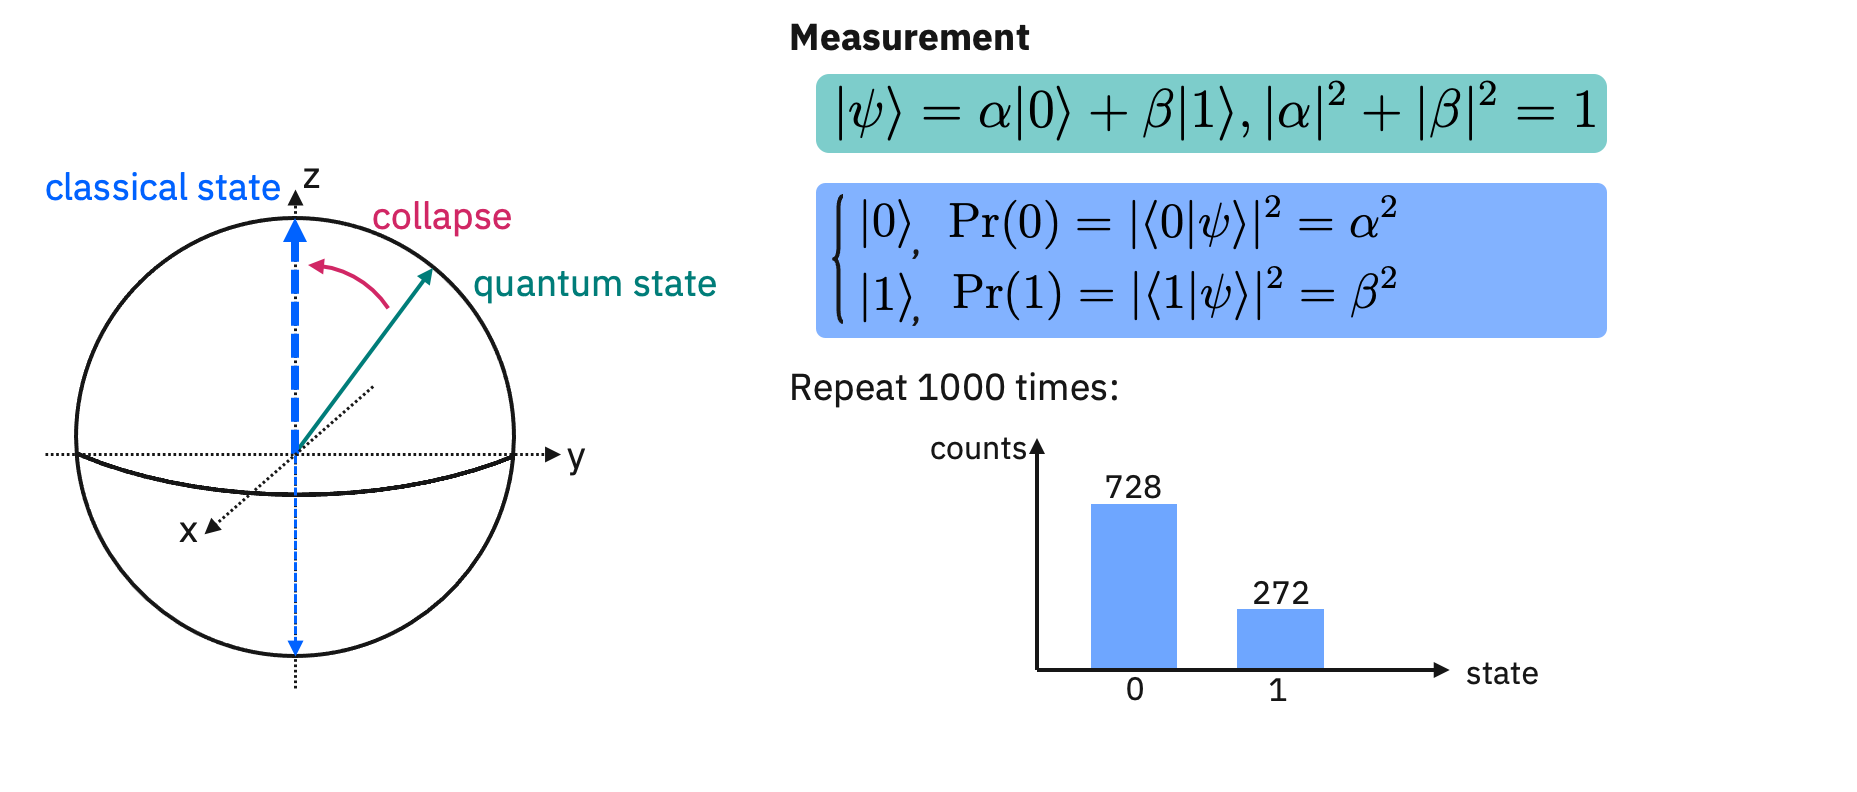

In [ ]:
bound.measure_all()
bound.draw("mpl", style="iqx")

In [ ]:
from qiskit import BasicAer, transpile

backend = BasicAer.get_backend("qasm_simulator")
transpiled = transpile(bound, backend)

transpiled.draw("mpl", style="iqx")

In [ ]:
from qiskit.visualization import plot_histogram

result = backend.run(transpiled, shots=1000).result()
counts = result.get_counts()

plot_histogram(counts)

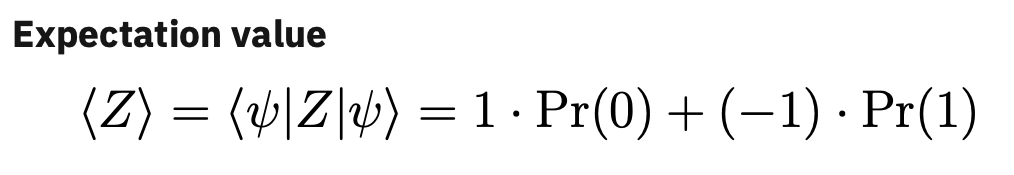

In [ ]:
from qiskit.opflow import *

state = StateFn(RealAmplitudes(1, reps=0))
op = X

exp = ~StateFn(op) @ state

